# 心臟肌肉影像分割 - 訓練模型

這個 notebook 用於訓練 3D U-Net 模型進行心臟肌肉影像分割

## 資料資訊
- 影像維度: 512 x 512 x 341
- 標籤類別: 4 類 (0: 背景, 1-3: 不同心臟組織)
- 訓練資料: 50 筆


## 1. 安裝必要套件


In [1]:
# 如果尚未安裝，請執行以下指令
!pip install torch torchvision nibabel numpy scikit-learn matplotlib tqdm scipy


## 2. 匯入套件


In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# 設定隨機種子
torch.manual_seed(42)
np.random.seed(42)

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')
if torch.cuda.is_available():
    print(f'GPU 名稱: {torch.cuda.get_device_name(0)}')


使用裝置: cuda
GPU 名稱: NVIDIA A100-SXM4-40GB


## 3. 資料集類別


In [3]:
class Augmentation3D:
    """3D 醫學影像資料增強"""

    def __init__(self,
                 rotation_range=15,      # 旋轉角度範圍（度）
                 flip_prob=0.5,          # 翻轉機率
                 noise_prob=0.3,         # 加噪聲機率
                 brightness_range=0.2,   # 亮度調整範圍
                 contrast_range=0.2,     # 對比度調整範圍
                 elastic_prob=0.3,       # 彈性變形機率
                 elastic_alpha=50,       # 彈性變形強度（位移場的標準差）
                 elastic_sigma=5):       # 彈性變形平滑度（高斯濾波器的標準差）
        self.rotation_range = rotation_range
        self.flip_prob = flip_prob
        self.noise_prob = noise_prob
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.elastic_prob = elastic_prob
        self.elastic_alpha = elastic_alpha
        self.elastic_sigma = elastic_sigma

    def __call__(self, image, label):
        """應用隨機增強"""
        # 1. 隨機旋轉（沿 Z 軸，即軸向）
        if np.random.random() < 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            image = self.rotate_3d(image, angle)
            label = self.rotate_3d(label, angle, is_label=True)

        # 2. 隨機翻轉（左右翻轉）
        if np.random.random() < self.flip_prob:
            image = np.flip(image, axis=0).copy()
            label = np.flip(label, axis=0).copy()

        # 3. 隨機翻轉（前後翻轉）
        if np.random.random() < self.flip_prob:
            image = np.flip(image, axis=1).copy()
            label = np.flip(label, axis=1).copy()

        # 4. 非剛性彈性變形（在翻轉之後、其他增強之前）
        if np.random.random() < self.elastic_prob:
            image, label = self.elastic_deform_3d(image, label)

        # 5. 隨機加高斯噪聲
        if np.random.random() < self.noise_prob:
            noise = np.random.normal(0, 0.05, image.shape)
            image = np.clip(image + noise, 0, 1)

        # 6. 隨機亮度調整
        if np.random.random() < 0.5:
            factor = 1 + np.random.uniform(-self.brightness_range, self.brightness_range)
            image = np.clip(image * factor, 0, 1)

        # 7. 隨機對比度調整
        if np.random.random() < 0.5:
            factor = 1 + np.random.uniform(-self.contrast_range, self.contrast_range)
            mean = image.mean()
            image = np.clip((image - mean) * factor + mean, 0, 1)

        return image, label

    def rotate_3d(self, volume, angle, is_label=False):
        """3D 旋轉（沿 Z 軸）"""
        from scipy import ndimage
        # 只旋轉 XY 平面（axes=(0,1)），保持 Z 軸不變
        if is_label:
            rotated = ndimage.rotate(volume, angle, axes=(0, 1), reshape=False, order=0, mode='nearest')
        else:
            rotated = ndimage.rotate(volume, angle, axes=(0, 1), reshape=False, order=1, mode='nearest')
        return rotated

    def elastic_deform_3d(self, image, label):
        """
        3D 非剛性彈性變形（Elastic Deformation）

        實現原理：
        1. 生成隨機位移場（displacement field）
        2. 對位移場進行高斯平滑，確保變形平滑連續
        3. 使用 scipy.ndimage.map_coordinates 應用變形

        Args:
            image: 輸入影像 (H, W, D)
            label: 輸入標籤 (H, W, D)

        Returns:
            deformed_image: 變形後的影像
            deformed_label: 變形後的標籤
        """
        from scipy import ndimage

        h, w, d = image.shape

        # 生成隨機位移場（每個方向獨立）
        # 位移場的大小與影像相同
        dx = np.random.randn(h, w, d) * self.elastic_alpha
        dy = np.random.randn(h, w, d) * self.elastic_alpha
        dz = np.random.randn(h, w, d) * self.elastic_alpha

        # 對位移場進行高斯平滑，確保變形平滑連續
        dx = ndimage.gaussian_filter(dx, sigma=self.elastic_sigma, mode='constant')
        dy = ndimage.gaussian_filter(dy, sigma=self.elastic_sigma, mode='constant')
        dz = ndimage.gaussian_filter(dz, sigma=self.elastic_sigma, mode='constant')

        # 建立座標網格
        x, y, z = np.meshgrid(np.arange(h), np.arange(w), np.arange(d), indexing='ij')

        # 應用位移
        x = x + dx
        y = y + dy
        z = z + dz

        # 確保座標在有效範圍內
        x = np.clip(x, 0, h - 1)
        y = np.clip(y, 0, w - 1)
        z = np.clip(z, 0, d - 1)

        # 應用變形到影像（使用線性插值）
        deformed_image = ndimage.map_coordinates(
            image,
            [x, y, z],
            order=1,  # 線性插值
            mode='constant',
            cval=0.0,
            prefilter=False
        )

        # 應用變形到標籤（使用最近鄰插值，保持標籤值不變）
        deformed_label = ndimage.map_coordinates(
            label,
            [x, y, z],
            order=0,  # 最近鄰插值
            mode='constant',
            cval=0,
            prefilter=False
        ).astype(label.dtype)

        return deformed_image, deformed_label


class PatchBasedHeartDataset(Dataset):
    """
    Patch-based 心臟影像分割資料集（優化版）

    特點：
    - 從完整的 3D 影像中隨機抽取固定大小的 patches
    - 每個 volume 可以產生多個 patches，增加訓練樣本數
    - 使用更高解析度（256x256x128），保留更多細節
    - 智能採樣：優先採樣包含前景（心臟組織）的區域
    - ⚡ 優化：預先載入和降採樣所有影像（在 __init__ 中執行一次）
    """

    def __init__(self, image_paths, label_paths,
                 patch_size=(112, 112, 112),
                 samples_per_volume=4,
                 augment=False,
                 foreground_ratio=0.7):
        """
        Args:
            image_paths: 影像檔案路徑列表
            label_paths: 標籤檔案路徑列表
            patch_size: Patch 大小 (H, W, D)
            samples_per_volume: 每個 volume 抽取的 patch 數量
            augment: 是否進行資料增強
            foreground_ratio: 前景採樣比例（70% 從前景區域採樣）
        """
        self.patch_size = patch_size
        self.samples_per_volume = samples_per_volume
        self.augment = augment
        self.foreground_ratio = foreground_ratio

        # 初始化增強器
        if self.augment:
            self.augmentor = Augmentation3D(
                rotation_range=15,
                flip_prob=0.5,
                noise_prob=0.3,
                brightness_range=0.2,
                contrast_range=0.2,
                elastic_prob=0.3,      # 彈性變形機率 30%
                elastic_alpha=50,        # 彈性變形強度
                elastic_sigma=5          # 彈性變形平滑度
            )

        # ⚡ 優化：預先載入、正規化和降採樣所有影像（只執行一次）
        print(f'⚡ 預先載入和處理 {len(image_paths)} 個 volumes...')
        self.images = []
        self.labels = []

        from scipy import ndimage
        target_size = (384, 384, 192)

        for i, (img_path, label_path) in enumerate(tqdm(
            zip(image_paths, label_paths),
            total=len(image_paths),
            desc='載入資料'
        )):
            # 讀取原始影像和標籤
            image = nib.load(img_path).get_fdata()
            label = nib.load(label_path).get_fdata()

            # 正規化影像
            image = self.normalize(image)

            # 降採樣到目標解析度
            zoom_factors = [target_size[i] / image.shape[i] for i in range(3)]
            image = ndimage.zoom(image, zoom_factors, order=1)
            label = ndimage.zoom(label, zoom_factors, order=0)

            # 儲存到記憶體
            self.images.append(image)
            self.labels.append(label)

        print(f'✅ 完成！所有資料已預先處理並載入記憶體')
        print(f'   - 影像形狀: {self.images[0].shape}')
        print(f'   - 記憶體使用: ~{len(self.images) * self.images[0].nbytes / (1024**3):.2f} GB')

    def __len__(self):
        # 總樣本數 = volume 數量 × 每個 volume 的 patch 數
        return len(self.images) * self.samples_per_volume

    def __getitem__(self, idx):
        # 計算對應的 volume index
        volume_idx = idx // self.samples_per_volume

        # ⚡ 直接從記憶體取得預處理好的影像（無需 I/O 和降採樣）
        image = self.images[volume_idx]
        label = self.labels[volume_idx]

        # 隨機抽取 patch
        image_patch, label_patch = self.extract_random_patch(image, label)

        # 資料增強（僅在訓練時）
        if self.augment:
            image_patch, label_patch = self.augmentor(image_patch, label_patch)

        # 轉換為 tensor
        image_patch = torch.from_numpy(image_patch).float().unsqueeze(0)  # (1, H, W, D)
        label_patch = torch.from_numpy(label_patch).long()  # (H, W, D)

        return image_patch, label_patch

    def extract_random_patch(self, image, label):
        """
        從完整影像中隨機抽取一個 patch
        智能採樣：70% 機率從前景區域採樣，30% 從任意位置採樣
        """
        h, w, d = image.shape
        ph, pw, pd = self.patch_size

        # 決定採樣策略
        if np.random.random() < self.foreground_ratio and label.sum() > 0:
            # 從前景區域採樣
            foreground_coords = np.where(label > 0)
            if len(foreground_coords[0]) > 0:
                # 隨機選擇一個前景點作為中心
                idx = np.random.randint(0, len(foreground_coords[0]))
                center_h = foreground_coords[0][idx]
                center_w = foreground_coords[1][idx]
                center_d = foreground_coords[2][idx]

                # 以前景點為中心，添加隨機偏移
                start_h = np.clip(center_h - ph // 2 + np.random.randint(-ph//4, ph//4), 0, h - ph)
                start_w = np.clip(center_w - pw // 2 + np.random.randint(-pw//4, pw//4), 0, w - pw)
                start_d = np.clip(center_d - pd // 2 + np.random.randint(-pd//4, pd//4), 0, d - pd)
            else:
                # 如果沒有前景，使用隨機採樣
                start_h = np.random.randint(0, max(1, h - ph))
                start_w = np.random.randint(0, max(1, w - pw))
                start_d = np.random.randint(0, max(1, d - pd))
        else:
            # 完全隨機採樣
            start_h = np.random.randint(0, max(1, h - ph))
            start_w = np.random.randint(0, max(1, w - pw))
            start_d = np.random.randint(0, max(1, d - pd))

        # 提取 patch
        image_patch = image[start_h:start_h+ph, start_w:start_w+pw, start_d:start_d+pd]
        label_patch = label[start_h:start_h+ph, start_w:start_w+pw, start_d:start_d+pd]

        return image_patch, label_patch

    def normalize(self, image):
        """正規化影像到 [0, 1]"""
        image = image.astype(np.float32)
        p1, p99 = np.percentile(image, (1, 99))
        image = np.clip(image, p1, p99)
        image = (image - p1) / (p99 - p1 + 1e-8)
        return image


## 4. 3D U-Net 模型


In [4]:
class ResidualConv3DBlock(nn.Module):
    """
    3D 殘差卷積區塊 (Residual 3D Convolution Block)

    引入殘差連接 (Skip Connection) 解決梯度消失問題，讓模型能學得更深、更細。

    結構：
    - 主路徑：Conv3d → BN → ReLU → Conv3d → BN
    - 殘差路徑：如果 in_channels != out_channels，使用 1x1x1 卷積匹配維度
    - 輸出：主路徑 + 殘差路徑 → ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # 主路徑：兩個 3x3x3 卷積
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # 殘差路徑：如果輸入輸出通道數不同，使用 1x1x1 卷積匹配維度
        if in_channels != out_channels:
            self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = None

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # 保存殘差連接的輸入
        residual = x

        # 主路徑
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 殘差連接：如果維度不匹配，先通過 1x1x1 卷積
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        # 主路徑 + 殘差路徑
        out = out + residual

        # 最終 ReLU
        out = self.relu2(out)

        return out


class UNet3D(nn.Module):
    """3D Residual U-Net 模型"""
    def __init__(self, in_channels=1, num_classes=4, base_channels=32):
        super().__init__()

        # Encoder
        self.enc1 = ResidualConv3DBlock(in_channels, base_channels)
        self.enc2 = ResidualConv3DBlock(base_channels, base_channels * 2)
        self.enc3 = ResidualConv3DBlock(base_channels * 2, base_channels * 4)
        self.enc4 = ResidualConv3DBlock(base_channels * 4, base_channels * 8)

        # Bottleneck
        self.bottleneck = ResidualConv3DBlock(base_channels * 8, base_channels * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(base_channels * 16, base_channels * 8, kernel_size=2, stride=2)
        self.dec4 = ResidualConv3DBlock(base_channels * 16, base_channels * 8)

        self.upconv3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = ResidualConv3DBlock(base_channels * 8, base_channels * 4)

        self.upconv2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualConv3DBlock(base_channels * 4, base_channels * 2)

        self.upconv1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = ResidualConv3DBlock(base_channels * 2, base_channels)

        # Output
        self.out = nn.Conv3d(base_channels, num_classes, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)


In [5]:
class DiceLoss(nn.Module):
    """Dice Loss for multi-class segmentation"""
    def __init__(self, num_classes=4):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        dice_loss = 0

        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice_loss += 1 - (2 * intersection + 1e-7) / (union + 1e-7)

        return dice_loss / self.num_classes


class BoundaryLoss(nn.Module):
    """
    邊界損失 (Boundary Loss) - 專門懲罰邊緣錯誤

    核心思想：
    1. 檢測預測和真實標籤的邊界
    2. 計算邊界區域的預測錯誤
    3. 對邊界錯誤給予更高的懲罰權重

    這有助於：
    - 提升分割邊界的精確度
    - 縮小 IoU 與 Dice 的差距
    - 減少邊緣的模糊和錯誤
    """
    def __init__(self, num_classes=4):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        """
        計算邊界損失

        Args:
            pred: 模型預測 (B, C, H, W, D)
            target: 真實標籤 (B, H, W, D)
        """
        import torch.nn.functional as F

        pred_softmax = torch.softmax(pred, dim=1)
        boundary_loss = 0

        for i in range(self.num_classes):
            # 取得當前類別的預測和真實標籤
            pred_i = pred_softmax[:, i]  # (B, H, W, D)
            target_i = (target == i).float()  # (B, H, W, D)

            # 計算邊界 (使用梯度檢測)
            # 對真實標籤計算梯度，梯度大的地方就是邊界
            target_boundary = self.compute_boundary(target_i)

            # 在邊界區域計算預測錯誤
            # 使用 BCE loss 在邊界區域
            boundary_error = F.binary_cross_entropy(
                pred_i,
                target_i,
                reduction='none'
            )

            # 只關注邊界區域的錯誤（給予更高權重）
            weighted_error = boundary_error * (1 + 2 * target_boundary)
            # 邊界區域權重 = 3, 非邊界區域權重 = 1

            boundary_loss += weighted_error.mean()

        return boundary_loss / self.num_classes

    def compute_boundary(self, mask):
        """
        計算 3D mask 的邊界
        使用 3D Sobel 算子檢測邊界

        Args:
            mask: (B, H, W, D) 二值 mask
        Returns:
            boundary: (B, H, W, D) 邊界 map，邊界處值較大
        """
        import torch.nn.functional as F

        # 使用簡單的梯度檢測
        # 計算三個方向的差分
        grad_x = torch.abs(mask[:, 1:, :, :] - mask[:, :-1, :, :])
        grad_y = torch.abs(mask[:, :, 1:, :] - mask[:, :, :-1, :])
        grad_z = torch.abs(mask[:, :, :, 1:] - mask[:, :, :, :-1])

        # Pad 回原始大小
        grad_x = F.pad(grad_x, (0, 0, 0, 0, 0, 1))
        grad_y = F.pad(grad_y, (0, 0, 0, 1, 0, 0))
        grad_z = F.pad(grad_z, (0, 1, 0, 0, 0, 0))

        # 合併三個方向的梯度
        boundary = (grad_x + grad_y + grad_z) > 0

        return boundary.float()


class CombinedLoss(nn.Module):
    """
    結合 CrossEntropy、Dice Loss 和 Boundary Loss

    配置：
    - CE (20%): 基礎的像素級分類損失 + 類別權重
    - Dice (50%): 整體區域重疊損失
    - Boundary (30%): 邊界精確度損失

    新增功能：
    - ⭐ CrossEntropy 類別權重：處理類別不平衡
    """
    def __init__(self, num_classes=4, weight_ce=0.2, weight_dice=0.5, weight_boundary=0.3,
                 class_weights=None, device='cuda'):
        super().__init__()

        # ⭐ 類別權重：處理類別不平衡問題
        if class_weights is None:
            # 預設權重：基於醫學影像分割經驗
            # 背景（class 0）權重較低，心臟組織（class 1-3）權重較高
            class_weights = torch.tensor([0.5, 1.5, 1.5, 1.5], dtype=torch.float32)
            print(f'🎯 使用預設類別權重：')
            print(f'   - 背景 (class 0): {class_weights[0]:.1f}')
            print(f'   - 心臟組織 (class 1-3): {class_weights[1]:.1f}')

        # ⭐ 重要：將權重移到正確的設備（GPU）
        if isinstance(class_weights, torch.Tensor):
            class_weights = class_weights.to(device)

        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.dice = DiceLoss(num_classes)
        self.boundary = BoundaryLoss(num_classes)
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.weight_boundary = weight_boundary

        print(f'\n📊 損失函數配置：')
        print(f'   CrossEntropy: {weight_ce:.1%} (含類別權重 ⭐)')
        print(f'   Dice Loss: {weight_dice:.1%}')
        print(f'   Boundary Loss: {weight_boundary:.1%}')

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target)

        return (self.weight_ce * ce_loss +
                self.weight_dice * dice_loss +
                self.weight_boundary * boundary_loss)


def dice_coefficient(pred, target, num_classes=4):
    """計算 Dice 係數"""
    pred = torch.argmax(pred, dim=1)
    dice_scores = []

    for i in range(1, num_classes):  # 跳過背景
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        if union > 0:
            dice = (2 * intersection) / (union + 1e-7)
            dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0


def iou_coefficient(pred, target, num_classes=4):
    """
    計算 IoU 係數 (Intersection over Union)
    IoU = Intersection / Union
    """
    pred = torch.argmax(pred, dim=1)
    iou_scores = []

    for i in range(1, num_classes):  # 跳過背景
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum() - intersection

        if union > 0:
            iou = intersection / (union + 1e-7)
            iou_scores.append(iou.item())

    return np.mean(iou_scores) if iou_scores else 0.0


def combined_score(pred, target, num_classes=4):
    """
    計算 Combined Score = (Dice + IoU) / 2
    這是比賽的評分標準
    """
    dice = dice_coefficient(pred, target, num_classes)
    iou = iou_coefficient(pred, target, num_classes)
    return (dice + iou) / 2.0


## 準備資料


## 5. 掛載 Google Drive (如果資料在雲端硬碟)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

# 假設您的資料夾結構是 /content/gdrive/MyDrive/aicup_data/training_image 和 /content/gdrive/MyDrive/aicup_data/training_label
# 請根據您的實際路徑調整
base_data_dir = '/content/gdrive/MyDrive/aicup_data'
image_dir = os.path.join(base_data_dir, 'training_image')
label_dir = os.path.join(base_data_dir, 'training_label')

# 檢查資料夾是否存在
if not os.path.exists(image_dir):
    print(f"錯誤：影像資料夾 '{image_dir}' 不存在。請檢查路徑或將資料上傳到指定位置。")
if not os.path.exists(label_dir):
    print(f"錯誤：標籤資料夾 '{label_dir}' 不存在。請檢查路徑或將資料上傳到指定位置。")

print(f'影像資料夾路徑: {image_dir}')
print(f'標籤資料夾路徑: {label_dir}')

Mounted at /content/gdrive
影像資料夾路徑: /content/gdrive/MyDrive/aicup_data/training_image
標籤資料夾路徑: /content/gdrive/MyDrive/aicup_data/training_label


In [7]:
# 取得所有訓練資料路徑
# image_dir 和 label_dir 變數已在前面的儲存格中設定為 Google Drive 路徑

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_paths = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

print(f'找到 {len(image_paths)} 個訓練影像')
print(f'找到 {len(label_paths)} 個訓練標籤')

# 檢查配對
for img_path, lbl_path in zip(image_paths[:3], label_paths[:3]):
    print(f'影像: {os.path.basename(img_path)} <-> 標籤: {os.path.basename(lbl_path)}')


找到 50 個訓練影像
找到 50 個訓練標籤
影像: patient0001.nii.gz <-> 標籤: patient0001_gt.nii.gz
影像: patient0002.nii.gz <-> 標籤: patient0002_gt.nii.gz
影像: patient0003.nii.gz <-> 標籤: patient0003_gt.nii.gz


In [8]:
# 分割訓練集和驗證集
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

print(f'訓練集: {len(train_images)} 筆')
print(f'驗證集: {len(val_images)} 筆')

# ==================== Patch-based Training 配置 ====================
print('\n' + '='*70)
print('🎯 使用 Patch-based Training 策略')
print('='*70)

# Patch 配置
PATCH_SIZE = (112, 112, 112)  # Patch 大小（比完整降採樣更小但解析度更高）
SAMPLES_PER_VOLUME = 4     # 每個 volume 抽取 4 個 patches
BATCH_SIZE = 4             # 3D 訓練採用小批次；可用梯度累積放大有效批次
GRAD_ACCUM_STEPS = 4       # 梯度累積步數（有效 batch = BATCH_SIZE × GRAD_ACCUM_STEPS）

print(f'\n📦 Patch 配置：')
print(f'   - Patch 大小: {PATCH_SIZE}')
print(f'   - 每個 volume 的 patch 數: {SAMPLES_PER_VOLUME}')
print(f'   - 批次大小: {BATCH_SIZE}')
print(f'   - 梯度累積步數: {GRAD_ACCUM_STEPS}')
print(f'   - 訓練樣本數: {len(train_images)} volumes × {SAMPLES_PER_VOLUME} = {len(train_images) * SAMPLES_PER_VOLUME} patches')
print(f'   - 驗證樣本數: {len(val_images)} volumes × {SAMPLES_PER_VOLUME} = {len(val_images) * SAMPLES_PER_VOLUME} patches')

# 建立 Patch-based 資料集
train_dataset = PatchBasedHeartDataset(
    train_images, train_labels,
    patch_size=PATCH_SIZE,
    samples_per_volume=SAMPLES_PER_VOLUME,
    augment=True,
    foreground_ratio=0.7  # 70% 從前景區域採樣
)

val_dataset = PatchBasedHeartDataset(
    val_images, val_labels,
    patch_size=PATCH_SIZE,
    samples_per_volume=SAMPLES_PER_VOLUME,
    augment=False,
    foreground_ratio=0.5  # 驗證時降低前景採樣比例，更全面評估
)

print('\n✅ 訓練集已啟用智能 Patch 採樣 + 3D 資料增強：')
print('   🎲 智能採樣：70% 從前景（心臟）區域採樣')
print('   🔄 隨機旋轉（±15度）')
print('   🔁 隨機翻轉（左右、前後）')
print('   🌊 非剛性彈性變形（30% 機率，模擬組織形變）')
print('   📊 隨機高斯噪聲')
print('   💡 隨機亮度調整（±20%）')
print('   🌗 隨機對比度調整（±20%）')

# 建立資料載入器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'\n訓練 batches: {len(train_loader)}')
print(f'驗證 batches: {len(val_loader)}')


訓練集: 40 筆
驗證集: 10 筆

🎯 使用 Patch-based Training 策略

📦 Patch 配置：
   - Patch 大小: (112, 112, 112)
   - 每個 volume 的 patch 數: 4
   - 批次大小: 4
   - 梯度累積步數: 4
   - 訓練樣本數: 40 volumes × 4 = 160 patches
   - 驗證樣本數: 10 volumes × 4 = 40 patches
⚡ 預先載入和處理 40 個 volumes...


載入資料: 100%|██████████| 40/40 [10:48<00:00, 16.21s/it]


✅ 完成！所有資料已預先處理並載入記憶體
   - 影像形狀: (384, 384, 192)
   - 記憶體使用: ~8.44 GB
⚡ 預先載入和處理 10 個 volumes...


載入資料: 100%|██████████| 10/10 [02:30<00:00, 15.02s/it]

✅ 完成！所有資料已預先處理並載入記憶體
   - 影像形狀: (384, 384, 192)
   - 記憶體使用: ~2.11 GB

✅ 訓練集已啟用智能 Patch 採樣 + 3D 資料增強：
   🎲 智能採樣：70% 從前景（心臟）區域採樣
   🔄 隨機旋轉（±15度）
   🔁 隨機翻轉（左右、前後）
   🌊 非剛性彈性變形（30% 機率，模擬組織形變）
   📊 隨機高斯噪聲
   💡 隨機亮度調整（±20%）
   🌗 隨機對比度調整（±20%）

訓練 batches: 40
驗證 batches: 10


## 7. 視覺化資料


展示資料增強效果（同一張影像的 4 次不同增強）



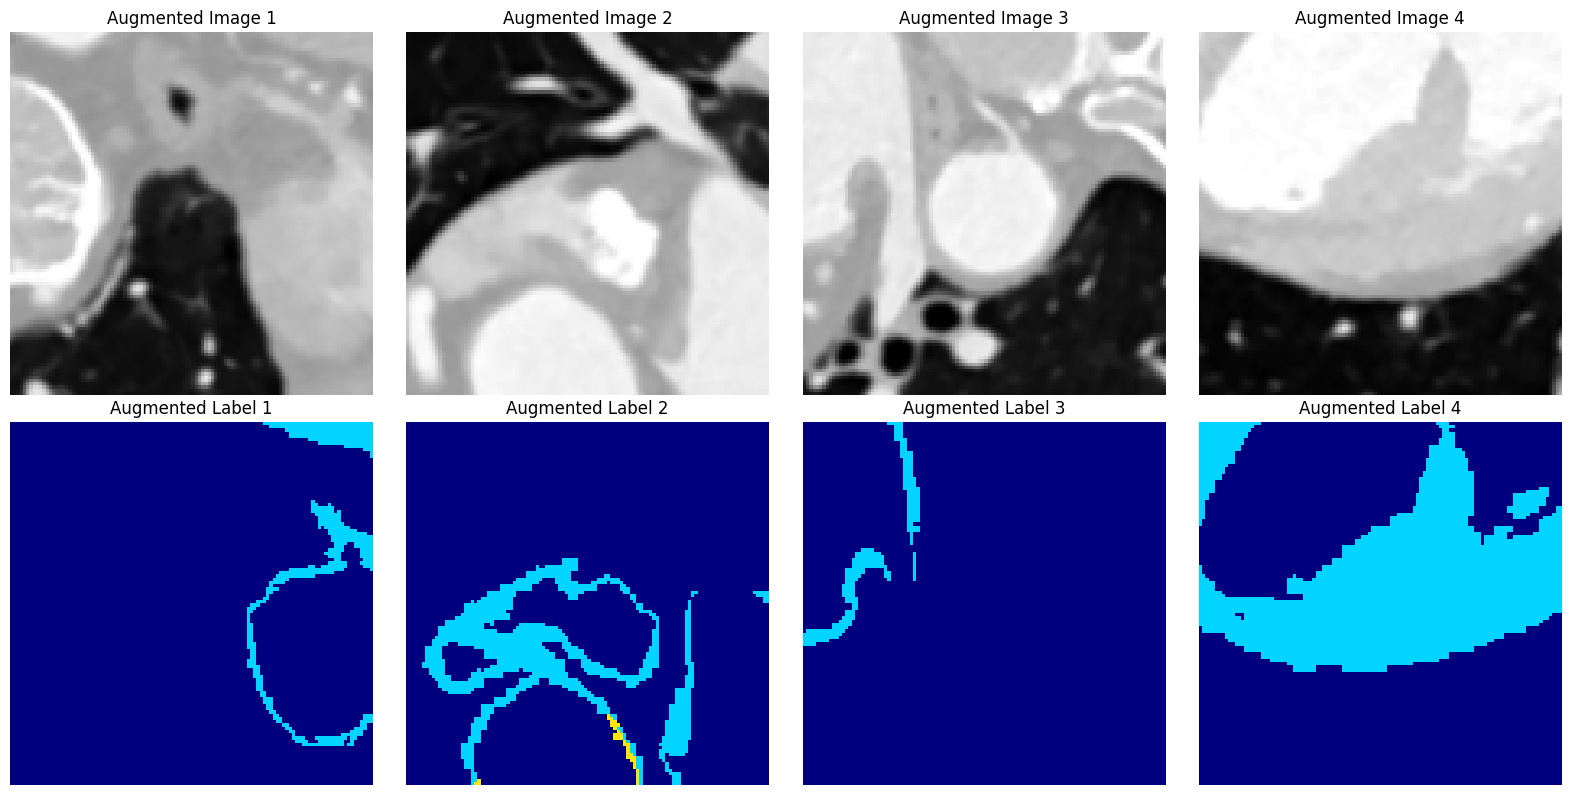


影像形狀: torch.Size([1, 112, 112, 112])
標籤形狀: torch.Size([112, 112, 112])
標籤類別: tensor([0, 1])


In [9]:
# 視覺化資料增強效果 - 同一張影像的多次增強結果
print('展示資料增強效果（同一張影像的 4 次不同增強）\n')

# 取得同一個索引的資料多次，每次都會套用不同的隨機增強
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # 每次呼叫都會產生不同的增強結果
    aug_image, aug_label = train_dataset[0]
    slice_idx = aug_image.shape[-1] // 2

    # 顯示增強後的影像
    axes[0, i].imshow(aug_image[0, :, :, slice_idx], cmap='gray')
    axes[0, i].set_title(f'Augmented Image {i+1}')
    axes[0, i].axis('off')

    # 顯示增強後的標籤
    axes[1, i].imshow(aug_label[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[1, i].set_title(f'Augmented Label {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()

# 顯示基本資訊
sample_image, sample_label = train_dataset[0]
print(f'\n影像形狀: {sample_image.shape}')
print(f'標籤形狀: {sample_label.shape}')
print(f'標籤類別: {torch.unique(sample_label)}')


## 8. 建立模型和訓練設定


In [10]:
# 建立模型
model = UNet3D(in_channels=1, num_classes=4, base_channels=48)  # 提升模型容量
model = model.to(device)

# 從頭開始訓練（不使用預訓練權重）
# 注意：由於 base_channels 已從 32 改為 48，模型架構已改變，需要重新訓練
print('🔄 從頭開始訓練（模型架構：base_channels=48）')

# 計算模型參數量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'總參數量: {total_params:,}')
print(f'可訓練參數量: {trainable_params:,}')

# 損失函數和優化器
print('='*70)
print('🔧 訓練配置')
print('='*70)

criterion = CombinedLoss(num_classes=4, weight_ce=0.2, weight_dice=0.45, weight_boundary=0.35, device=device)

# ⭐ 加入 L2 正則化 (Weight Decay)
WEIGHT_DECAY = 1e-4  # L2 正則化強度
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=WEIGHT_DECAY)  # ⭐ Learning Rate: 1e-4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)  # ⭐ patience=10

print(f'\n⚙️ 優化器配置：')
print(f'   - Optimizer: Adam')
print(f'   - Learning Rate: 1e-4')
print(f'   - Weight Decay (L2): {WEIGHT_DECAY} ⭐ 防止過擬合')
print(f'   - Scheduler: ReduceLROnPlateau (patience=10, factor=0.5) ⭐ 更有耐心')

# 訓練設定
NUM_EPOCHS = 150  # ⭐ 150 epochs
SAVE_DIR = 'checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

print(f'\n📅 訓練設定：')
print(f'   - Epochs: {NUM_EPOCHS}')
print(f'   - Checkpoint 目錄: {SAVE_DIR}')
print('='*70 + '\n')


🔄 從頭開始訓練（模型架構：base_channels=48）
總參數量: 51,585,844
可訓練參數量: 51,585,844
🔧 訓練配置
🎯 使用預設類別權重：
   - 背景 (class 0): 0.5
   - 心臟組織 (class 1-3): 1.5

📊 損失函數配置：
   CrossEntropy: 20.0% (含類別權重 ⭐)
   Dice Loss: 45.0%
   Boundary Loss: 35.0%

⚙️ 優化器配置：
   - Optimizer: Adam
   - Learning Rate: 1e-4
   - Weight Decay (L2): 0.0001 ⭐ 防止過擬合
   - Scheduler: ReduceLROnPlateau (patience=10, factor=0.5) ⭐ 更有耐心

📅 訓練設定：
   - Epochs: 150
   - Checkpoint 目錄: checkpoints



## 9. 訓練函數


In [11]:
def train_epoch(model, loader, criterion, optimizer, device, grad_accum_steps=1):
    """訓練一個 epoch"""
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_score = 0

    optimizer.zero_grad()
    num_batches = len(loader)
    pbar = tqdm(loader, desc='Training')
    for step, (images, labels) in enumerate(pbar, start=1):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss_raw = criterion(outputs, labels)
        loss = loss_raw / max(1, grad_accum_steps)

        # Backward
        loss.backward()
        if (step % grad_accum_steps == 0) or (step == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        # 計算評估指標
        dice = dice_coefficient(outputs, labels)
        iou = iou_coefficient(outputs, labels)
        score = combined_score(outputs, labels)

        total_loss += loss_raw.item()
        total_dice += dice
        total_iou += iou
        total_score += score

        pbar.set_postfix({
            'loss': f'{loss_raw.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}',
            'score': f'{score:.4f}'
        })

    return (total_loss / len(loader),
            total_dice / len(loader),
            total_iou / len(loader),
            total_score / len(loader))


def validate_epoch(model, loader, criterion, device):
    """驗證一個 epoch"""
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_score = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # 計算評估指標
            dice = dice_coefficient(outputs, labels)
            iou = iou_coefficient(outputs, labels)
            score = combined_score(outputs, labels)

            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            total_score += score

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'score': f'{score:.4f}'
            })

    return (total_loss / len(loader),
            total_dice / len(loader),
            total_iou / len(loader),
            total_score / len(loader))


In [12]:
# 訓練歷史
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'train_score': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'val_score': []
}

best_val_score = 0.0  # 使用 Combined Score 選擇最佳模型

print('開始訓練...\\n')
print('📊 評分標準：Combined Score = (Dice + IoU) / 2')
print('='*60 + '\\n')

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 60)

    # 訓練
    train_loss, train_dice, train_iou, train_score = train_epoch(
        model, train_loader, criterion, optimizer, device, grad_accum_steps=GRAD_ACCUM_STEPS
    )

    # 驗證
    val_loss, val_dice, val_iou, val_score = validate_epoch(
        model, val_loader, criterion, device
    )

    # 更新學習率
    scheduler.step(val_loss)

    # 記錄歷史
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['train_score'].append(train_score)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['val_score'].append(val_score)

    # 顯示結果
    print(f'\\n📈 Training:')
    print(f'   Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} | Score: {train_score:.4f}')
    print(f'📊 Validation:')
    print(f'   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Score: {val_score:.4f}')
    print(f'🔧 Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\\n')

    # 儲存最佳模型（使用 Combined Score）
    if val_score > best_val_score:
        best_val_score = val_score
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
            'val_score': val_score,
        }, os.path.join(SAVE_DIR, 'best_model.pth'))
        print(f'✅ 儲存最佳模型！')
        print(f'   Combined Score: {val_score:.4f} (Dice: {val_dice:.4f}, IoU: {val_iou:.4f})\\n')

    # 定期儲存檢查點
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
            'val_score': val_score,
        }, os.path.join(SAVE_DIR, f'checkpoint_epoch_{epoch+1}.pth'))

print('='*60)
print('🎉 訓練完成！')
print(f'🏆 最佳 Combined Score: {best_val_score:.4f}')
print('='*60)


開始訓練...\n
📊 評分標準：Combined Score = (Dice + IoU) / 2
============================================================\n
Epoch 1/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=0.8062, dice=0.1429, iou=0.0909, score=0.1169]


\n📈 Training:
   Loss: 0.8052 | Dice: 0.1297 | IoU: 0.0815 | Score: 0.1056
📊 Validation:
   Loss: 0.7690 | Dice: 0.1218 | IoU: 0.0758 | Score: 0.0988
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.0988 (Dice: 0.1218, IoU: 0.0758)\n
Epoch 2/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s, loss=0.8626, dice=0.1029, iou=0.0607, score=0.0818]


\n📈 Training:
   Loss: 0.7144 | Dice: 0.1512 | IoU: 0.0995 | Score: 0.1253
📊 Validation:
   Loss: 0.6815 | Dice: 0.1654 | IoU: 0.1131 | Score: 0.1393
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.1393 (Dice: 0.1654, IoU: 0.1131)\n
Epoch 3/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s, loss=0.6324, dice=0.1768, iou=0.1203, score=0.1485]


\n📈 Training:
   Loss: 0.6638 | Dice: 0.1706 | IoU: 0.1173 | Score: 0.1439
📊 Validation:
   Loss: 0.5864 | Dice: 0.1821 | IoU: 0.1279 | Score: 0.1550
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.1550 (Dice: 0.1821, IoU: 0.1279)\n
Epoch 4/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.6510, dice=0.1284, iou=0.0795, score=0.1040]


\n📈 Training:
   Loss: 0.6193 | Dice: 0.1955 | IoU: 0.1404 | Score: 0.1679
📊 Validation:
   Loss: 0.5754 | Dice: 0.1855 | IoU: 0.1351 | Score: 0.1603
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.1603 (Dice: 0.1855, IoU: 0.1351)\n
Epoch 5/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s, loss=0.7110, dice=0.1786, iou=0.1087, score=0.1437]


\n📈 Training:
   Loss: 0.5786 | Dice: 0.2324 | IoU: 0.1700 | Score: 0.2012
📊 Validation:
   Loss: 0.5850 | Dice: 0.2140 | IoU: 0.1525 | Score: 0.1833
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.1833 (Dice: 0.2140, IoU: 0.1525)\n
Epoch 6/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.6286, dice=0.2789, iou=0.1934, score=0.2362]


\n📈 Training:
   Loss: 0.5684 | Dice: 0.2683 | IoU: 0.1967 | Score: 0.2325
📊 Validation:
   Loss: 0.4954 | Dice: 0.3408 | IoU: 0.2670 | Score: 0.3039
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.3039 (Dice: 0.3408, IoU: 0.2670)\n
Epoch 7/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s, loss=0.5336, dice=0.3130, iou=0.2278, score=0.2704]


\n📈 Training:
   Loss: 0.5309 | Dice: 0.3093 | IoU: 0.2316 | Score: 0.2704
📊 Validation:
   Loss: 0.4961 | Dice: 0.3199 | IoU: 0.2469 | Score: 0.2834
🔧 Learning Rate: 0.000100\n
Epoch 8/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.4873, dice=0.5623, iou=0.3911, score=0.4767]


\n📈 Training:
   Loss: 0.4972 | Dice: 0.3178 | IoU: 0.2424 | Score: 0.2801
📊 Validation:
   Loss: 0.4357 | Dice: 0.3851 | IoU: 0.3073 | Score: 0.3462
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.3462 (Dice: 0.3851, IoU: 0.3073)\n
Epoch 9/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.5458, dice=0.3265, iou=0.2424, score=0.2844]


\n📈 Training:
   Loss: 0.4746 | Dice: 0.3467 | IoU: 0.2679 | Score: 0.3073
📊 Validation:
   Loss: 0.4695 | Dice: 0.3327 | IoU: 0.2618 | Score: 0.2973
🔧 Learning Rate: 0.000100\n
Epoch 10/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.4247, dice=0.3503, iou=0.2696, score=0.3099]


\n📈 Training:
   Loss: 0.4642 | Dice: 0.3266 | IoU: 0.2516 | Score: 0.2891
📊 Validation:
   Loss: 0.4038 | Dice: 0.3437 | IoU: 0.2777 | Score: 0.3107
🔧 Learning Rate: 0.000100\n
Epoch 11/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.4332, dice=0.3379, iou=0.2552, score=0.2966]


\n📈 Training:
   Loss: 0.4405 | Dice: 0.3357 | IoU: 0.2592 | Score: 0.2974
📊 Validation:
   Loss: 0.4011 | Dice: 0.3613 | IoU: 0.2958 | Score: 0.3286
🔧 Learning Rate: 0.000100\n
Epoch 12/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss=0.3888, dice=0.4092, iou=0.3462, score=0.3777]


\n📈 Training:
   Loss: 0.4350 | Dice: 0.3267 | IoU: 0.2548 | Score: 0.2907
📊 Validation:
   Loss: 0.4091 | Dice: 0.3506 | IoU: 0.2809 | Score: 0.3157
🔧 Learning Rate: 0.000100\n
Epoch 13/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.4210, dice=0.3396, iou=0.2571, score=0.2984]


\n📈 Training:
   Loss: 0.4171 | Dice: 0.3460 | IoU: 0.2729 | Score: 0.3095
📊 Validation:
   Loss: 0.3849 | Dice: 0.3718 | IoU: 0.2929 | Score: 0.3324
🔧 Learning Rate: 0.000100\n
Epoch 14/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.4879, dice=0.2829, iou=0.1972, score=0.2400]


\n📈 Training:
   Loss: 0.4020 | Dice: 0.3634 | IoU: 0.2900 | Score: 0.3267
📊 Validation:
   Loss: 0.3911 | Dice: 0.3766 | IoU: 0.2942 | Score: 0.3354
🔧 Learning Rate: 0.000100\n
Epoch 15/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s, loss=0.4693, dice=0.3129, iou=0.2277, score=0.2703]


\n📈 Training:
   Loss: 0.3952 | Dice: 0.3672 | IoU: 0.2985 | Score: 0.3328
📊 Validation:
   Loss: 0.3799 | Dice: 0.4054 | IoU: 0.3373 | Score: 0.3713
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.3713 (Dice: 0.4054, IoU: 0.3373)\n
Epoch 16/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s, loss=0.4790, dice=0.2799, iou=0.1943, score=0.2371]


\n📈 Training:
   Loss: 0.4085 | Dice: 0.3401 | IoU: 0.2701 | Score: 0.3051
📊 Validation:
   Loss: 0.3948 | Dice: 0.3399 | IoU: 0.2702 | Score: 0.3050
🔧 Learning Rate: 0.000100\n
Epoch 17/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.3738, dice=0.4466, iou=0.2875, score=0.3670]


\n📈 Training:
   Loss: 0.3927 | Dice: 0.3873 | IoU: 0.3120 | Score: 0.3496
📊 Validation:
   Loss: 0.3628 | Dice: 0.3779 | IoU: 0.3017 | Score: 0.3398
🔧 Learning Rate: 0.000100\n
Epoch 18/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=0.4733, dice=0.3238, iou=0.2394, score=0.2816]


\n📈 Training:
   Loss: 0.3896 | Dice: 0.3671 | IoU: 0.2943 | Score: 0.3307
📊 Validation:
   Loss: 0.3844 | Dice: 0.3533 | IoU: 0.2865 | Score: 0.3199
🔧 Learning Rate: 0.000100\n
Epoch 19/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss=0.3800, dice=0.7520, iou=0.6026, score=0.6773]


\n📈 Training:
   Loss: 0.3772 | Dice: 0.3847 | IoU: 0.3120 | Score: 0.3483
📊 Validation:
   Loss: 0.3928 | Dice: 0.3924 | IoU: 0.3195 | Score: 0.3559
🔧 Learning Rate: 0.000100\n
Epoch 20/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.4172, dice=0.3448, iou=0.2632, score=0.3040]


\n📈 Training:
   Loss: 0.3702 | Dice: 0.3547 | IoU: 0.2887 | Score: 0.3217
📊 Validation:
   Loss: 0.3628 | Dice: 0.3677 | IoU: 0.3060 | Score: 0.3369
🔧 Learning Rate: 0.000100\n
Epoch 21/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss=0.3973, dice=0.3768, iou=0.3023, score=0.3396]


\n📈 Training:
   Loss: 0.3664 | Dice: 0.3675 | IoU: 0.3038 | Score: 0.3357
📊 Validation:
   Loss: 0.3422 | Dice: 0.4396 | IoU: 0.3769 | Score: 0.4082
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.4082 (Dice: 0.4396, IoU: 0.3769)\n
Epoch 22/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s, loss=0.4259, dice=0.3446, iou=0.2628, score=0.3037]


\n📈 Training:
   Loss: 0.3748 | Dice: 0.3630 | IoU: 0.2950 | Score: 0.3290
📊 Validation:
   Loss: 0.3637 | Dice: 0.3667 | IoU: 0.2992 | Score: 0.3330
🔧 Learning Rate: 0.000100\n
Epoch 23/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, loss=0.4250, dice=0.3158, iou=0.2206, score=0.2682]


\n📈 Training:
   Loss: 0.3792 | Dice: 0.3697 | IoU: 0.2946 | Score: 0.3321
📊 Validation:
   Loss: 0.3698 | Dice: 0.3709 | IoU: 0.2888 | Score: 0.3299
🔧 Learning Rate: 0.000100\n
Epoch 24/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.4061, dice=0.3856, iou=0.2973, score=0.3414]


\n📈 Training:
   Loss: 0.3709 | Dice: 0.3878 | IoU: 0.3088 | Score: 0.3483
📊 Validation:
   Loss: 0.3586 | Dice: 0.4098 | IoU: 0.3246 | Score: 0.3672
🔧 Learning Rate: 0.000100\n
Epoch 25/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s, loss=0.3445, dice=0.4339, iou=0.3658, score=0.3998]


\n📈 Training:
   Loss: 0.3640 | Dice: 0.4218 | IoU: 0.3301 | Score: 0.3760
📊 Validation:
   Loss: 0.3515 | Dice: 0.4046 | IoU: 0.3225 | Score: 0.3635
🔧 Learning Rate: 0.000100\n
Epoch 26/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, loss=0.3805, dice=0.3951, iou=0.3079, score=0.3515]


\n📈 Training:
   Loss: 0.3525 | Dice: 0.4199 | IoU: 0.3365 | Score: 0.3782
📊 Validation:
   Loss: 0.3211 | Dice: 0.4404 | IoU: 0.3643 | Score: 0.4023
🔧 Learning Rate: 0.000100\n
Epoch 27/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, loss=0.3293, dice=0.5481, iou=0.4403, score=0.4942]


\n📈 Training:
   Loss: 0.3517 | Dice: 0.4272 | IoU: 0.3403 | Score: 0.3837
📊 Validation:
   Loss: 0.3239 | Dice: 0.4683 | IoU: 0.3825 | Score: 0.4254
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.4254 (Dice: 0.4683, IoU: 0.3825)\n
Epoch 28/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s, loss=0.3403, dice=0.4573, iou=0.3618, score=0.4096]


\n📈 Training:
   Loss: 0.3472 | Dice: 0.4383 | IoU: 0.3522 | Score: 0.3952
📊 Validation:
   Loss: 0.3229 | Dice: 0.4450 | IoU: 0.3628 | Score: 0.4039
🔧 Learning Rate: 0.000100\n
Epoch 29/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.3335, dice=0.5837, iou=0.4516, score=0.5177]


\n📈 Training:
   Loss: 0.3486 | Dice: 0.4547 | IoU: 0.3568 | Score: 0.4058
📊 Validation:
   Loss: 0.3244 | Dice: 0.4982 | IoU: 0.4005 | Score: 0.4494
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.4494 (Dice: 0.4982, IoU: 0.4005)\n
Epoch 30/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.3660, dice=0.5159, iou=0.3943, score=0.4551]


\n📈 Training:
   Loss: 0.3474 | Dice: 0.4721 | IoU: 0.3634 | Score: 0.4177
📊 Validation:
   Loss: 0.3190 | Dice: 0.4968 | IoU: 0.3969 | Score: 0.4469
🔧 Learning Rate: 0.000100\n
Epoch 31/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.3354, dice=0.5739, iou=0.4212, score=0.4976]


\n📈 Training:
   Loss: 0.3306 | Dice: 0.5239 | IoU: 0.4072 | Score: 0.4656
📊 Validation:
   Loss: 0.3136 | Dice: 0.5615 | IoU: 0.4312 | Score: 0.4964
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.4964 (Dice: 0.5615, IoU: 0.4312)\n
Epoch 32/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s, loss=0.3482, dice=0.5605, iou=0.4089, score=0.4847]


\n📈 Training:
   Loss: 0.3236 | Dice: 0.5339 | IoU: 0.4188 | Score: 0.4764
📊 Validation:
   Loss: 0.3192 | Dice: 0.5623 | IoU: 0.4305 | Score: 0.4964
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.4964 (Dice: 0.5623, IoU: 0.4305)\n
Epoch 33/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.3645, dice=0.4085, iou=0.3042, score=0.3563]


\n📈 Training:
   Loss: 0.3154 | Dice: 0.5552 | IoU: 0.4354 | Score: 0.4953
📊 Validation:
   Loss: 0.3131 | Dice: 0.5307 | IoU: 0.4154 | Score: 0.4731
🔧 Learning Rate: 0.000100\n
Epoch 34/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.3619, dice=0.6238, iou=0.4579, score=0.5409]


\n📈 Training:
   Loss: 0.3066 | Dice: 0.5604 | IoU: 0.4404 | Score: 0.5004
📊 Validation:
   Loss: 0.2912 | Dice: 0.5975 | IoU: 0.4783 | Score: 0.5379
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.5379 (Dice: 0.5975, IoU: 0.4783)\n
Epoch 35/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.3253, dice=0.6327, iou=0.4893, score=0.5610]


\n📈 Training:
   Loss: 0.3078 | Dice: 0.5515 | IoU: 0.4322 | Score: 0.4919
📊 Validation:
   Loss: 0.3179 | Dice: 0.5619 | IoU: 0.4320 | Score: 0.4969
🔧 Learning Rate: 0.000100\n
Epoch 36/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=0.3112, dice=0.6164, iou=0.4579, score=0.5372]


\n📈 Training:
   Loss: 0.3056 | Dice: 0.5743 | IoU: 0.4482 | Score: 0.5113
📊 Validation:
   Loss: 0.2996 | Dice: 0.5873 | IoU: 0.4565 | Score: 0.5219
🔧 Learning Rate: 0.000100\n
Epoch 37/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.3228, dice=0.4024, iou=0.3367, score=0.3696]


\n📈 Training:
   Loss: 0.2972 | Dice: 0.5543 | IoU: 0.4424 | Score: 0.4983
📊 Validation:
   Loss: 0.2660 | Dice: 0.6037 | IoU: 0.5049 | Score: 0.5543
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.5543 (Dice: 0.6037, IoU: 0.5049)\n
Epoch 38/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s, loss=0.3431, dice=0.5098, iou=0.3493, score=0.4296]


\n📈 Training:
   Loss: 0.2970 | Dice: 0.5994 | IoU: 0.4716 | Score: 0.5355
📊 Validation:
   Loss: 0.2794 | Dice: 0.6110 | IoU: 0.4834 | Score: 0.5472
🔧 Learning Rate: 0.000100\n
Epoch 39/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s, loss=0.3132, dice=0.5559, iou=0.4353, score=0.4956]


\n📈 Training:
   Loss: 0.2949 | Dice: 0.5958 | IoU: 0.4730 | Score: 0.5344
📊 Validation:
   Loss: 0.3023 | Dice: 0.6100 | IoU: 0.4790 | Score: 0.5445
🔧 Learning Rate: 0.000100\n
Epoch 40/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s, loss=0.2769, dice=0.6659, iou=0.5261, score=0.5960]


\n📈 Training:
   Loss: 0.2962 | Dice: 0.5996 | IoU: 0.4782 | Score: 0.5389
📊 Validation:
   Loss: 0.2877 | Dice: 0.5817 | IoU: 0.4610 | Score: 0.5214
🔧 Learning Rate: 0.000100\n
Epoch 41/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=0.2803, dice=0.7288, iou=0.5882, score=0.6585]


\n📈 Training:
   Loss: 0.2849 | Dice: 0.6087 | IoU: 0.4868 | Score: 0.5478
📊 Validation:
   Loss: 0.2614 | Dice: 0.6843 | IoU: 0.5610 | Score: 0.6227
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6227 (Dice: 0.6843, IoU: 0.5610)\n
Epoch 42/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.2664, dice=0.6038, iou=0.4979, score=0.5509]


\n📈 Training:
   Loss: 0.2843 | Dice: 0.6145 | IoU: 0.4888 | Score: 0.5516
📊 Validation:
   Loss: 0.2937 | Dice: 0.5388 | IoU: 0.4369 | Score: 0.4879
🔧 Learning Rate: 0.000100\n
Epoch 43/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s, loss=0.2727, dice=0.4855, iou=0.4219, score=0.4537]


\n📈 Training:
   Loss: 0.2850 | Dice: 0.6124 | IoU: 0.4858 | Score: 0.5491
📊 Validation:
   Loss: 0.2817 | Dice: 0.6100 | IoU: 0.4896 | Score: 0.5498
🔧 Learning Rate: 0.000100\n
Epoch 44/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s, loss=0.2668, dice=0.6689, iou=0.5464, score=0.6076]


\n📈 Training:
   Loss: 0.2908 | Dice: 0.6275 | IoU: 0.4983 | Score: 0.5629
📊 Validation:
   Loss: 0.2669 | Dice: 0.6113 | IoU: 0.5038 | Score: 0.5575
🔧 Learning Rate: 0.000100\n
Epoch 45/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.3210, dice=0.6715, iou=0.5093, score=0.5904]


\n📈 Training:
   Loss: 0.2674 | Dice: 0.6811 | IoU: 0.5499 | Score: 0.6155
📊 Validation:
   Loss: 0.2548 | Dice: 0.6887 | IoU: 0.5617 | Score: 0.6252
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6252 (Dice: 0.6887, IoU: 0.5617)\n
Epoch 46/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=0.2242, dice=0.7563, iou=0.6278, score=0.6920]


\n📈 Training:
   Loss: 0.2731 | Dice: 0.6350 | IoU: 0.5094 | Score: 0.5722
📊 Validation:
   Loss: 0.2644 | Dice: 0.6551 | IoU: 0.5329 | Score: 0.5940
🔧 Learning Rate: 0.000100\n
Epoch 47/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2483, dice=0.7417, iou=0.6123, score=0.6770]


\n📈 Training:
   Loss: 0.2702 | Dice: 0.6567 | IoU: 0.5305 | Score: 0.5936
📊 Validation:
   Loss: 0.2786 | Dice: 0.6787 | IoU: 0.5448 | Score: 0.6118
🔧 Learning Rate: 0.000100\n
Epoch 48/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s, loss=0.2749, dice=0.6935, iou=0.5458, score=0.6197]


\n📈 Training:
   Loss: 0.2739 | Dice: 0.6456 | IoU: 0.5210 | Score: 0.5833
📊 Validation:
   Loss: 0.2732 | Dice: 0.6336 | IoU: 0.5126 | Score: 0.5731
🔧 Learning Rate: 0.000100\n
Epoch 49/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2822, dice=0.6714, iou=0.5240, score=0.5977]


\n📈 Training:
   Loss: 0.2664 | Dice: 0.6654 | IoU: 0.5375 | Score: 0.6015
📊 Validation:
   Loss: 0.2655 | Dice: 0.6806 | IoU: 0.5591 | Score: 0.6198
🔧 Learning Rate: 0.000100\n
Epoch 50/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, loss=0.2965, dice=0.7032, iou=0.5529, score=0.6280]


\n📈 Training:
   Loss: 0.2711 | Dice: 0.6747 | IoU: 0.5462 | Score: 0.6105
📊 Validation:
   Loss: 0.2742 | Dice: 0.6653 | IoU: 0.5493 | Score: 0.6073
🔧 Learning Rate: 0.000100\n
Epoch 51/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, loss=0.2582, dice=0.7300, iou=0.5861, score=0.6580]


\n📈 Training:
   Loss: 0.2726 | Dice: 0.6137 | IoU: 0.4968 | Score: 0.5553
📊 Validation:
   Loss: 0.2648 | Dice: 0.6679 | IoU: 0.5338 | Score: 0.6009
🔧 Learning Rate: 0.000100\n
Epoch 52/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.3038, dice=0.7633, iou=0.6282, score=0.6957]


\n📈 Training:
   Loss: 0.2619 | Dice: 0.6657 | IoU: 0.5426 | Score: 0.6041
📊 Validation:
   Loss: 0.2607 | Dice: 0.6552 | IoU: 0.5397 | Score: 0.5974
🔧 Learning Rate: 0.000100\n
Epoch 53/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s, loss=0.2553, dice=0.7588, iou=0.6233, score=0.6910]


\n📈 Training:
   Loss: 0.2622 | Dice: 0.6388 | IoU: 0.5217 | Score: 0.5803
📊 Validation:
   Loss: 0.2470 | Dice: 0.7070 | IoU: 0.5808 | Score: 0.6439
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6439 (Dice: 0.7070, IoU: 0.5808)\n
Epoch 54/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s, loss=0.3017, dice=0.7179, iou=0.5644, score=0.6412]


\n📈 Training:
   Loss: 0.2617 | Dice: 0.6682 | IoU: 0.5444 | Score: 0.6063
📊 Validation:
   Loss: 0.2537 | Dice: 0.7122 | IoU: 0.5919 | Score: 0.6521
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6521 (Dice: 0.7122, IoU: 0.5919)\n
Epoch 55/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2659, dice=0.7213, iou=0.5679, score=0.6446]


\n📈 Training:
   Loss: 0.2632 | Dice: 0.6314 | IoU: 0.5124 | Score: 0.5719
📊 Validation:
   Loss: 0.2704 | Dice: 0.6709 | IoU: 0.5363 | Score: 0.6036
🔧 Learning Rate: 0.000100\n
Epoch 56/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s, loss=0.2589, dice=0.7305, iou=0.6026, score=0.6666]


\n📈 Training:
   Loss: 0.2605 | Dice: 0.6575 | IoU: 0.5347 | Score: 0.5961
📊 Validation:
   Loss: 0.2646 | Dice: 0.6425 | IoU: 0.5180 | Score: 0.5803
🔧 Learning Rate: 0.000100\n
Epoch 57/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, loss=0.2650, dice=0.7227, iou=0.5871, score=0.6549]


\n📈 Training:
   Loss: 0.2594 | Dice: 0.6749 | IoU: 0.5489 | Score: 0.6119
📊 Validation:
   Loss: 0.2560 | Dice: 0.6809 | IoU: 0.5588 | Score: 0.6199
🔧 Learning Rate: 0.000100\n
Epoch 58/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s, loss=0.2838, dice=0.6833, iou=0.5346, score=0.6090]


\n📈 Training:
   Loss: 0.2525 | Dice: 0.6824 | IoU: 0.5562 | Score: 0.6193
📊 Validation:
   Loss: 0.2582 | Dice: 0.6952 | IoU: 0.5763 | Score: 0.6358
🔧 Learning Rate: 0.000100\n
Epoch 59/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s, loss=0.2374, dice=0.7265, iou=0.5849, score=0.6557]


\n📈 Training:
   Loss: 0.2639 | Dice: 0.6676 | IoU: 0.5425 | Score: 0.6051
📊 Validation:
   Loss: 0.2434 | Dice: 0.7218 | IoU: 0.5927 | Score: 0.6572
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6572 (Dice: 0.7218, IoU: 0.5927)\n
Epoch 60/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, loss=0.3119, dice=0.6674, iou=0.5037, score=0.5856]


\n📈 Training:
   Loss: 0.2579 | Dice: 0.6772 | IoU: 0.5570 | Score: 0.6171
📊 Validation:
   Loss: 0.2572 | Dice: 0.6712 | IoU: 0.5478 | Score: 0.6095
🔧 Learning Rate: 0.000100\n
Epoch 61/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.2782, dice=0.7428, iou=0.6063, score=0.6745]


\n📈 Training:
   Loss: 0.2550 | Dice: 0.6625 | IoU: 0.5432 | Score: 0.6028
📊 Validation:
   Loss: 0.2544 | Dice: 0.7388 | IoU: 0.6023 | Score: 0.6705
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6705 (Dice: 0.7388, IoU: 0.6023)\n
Epoch 62/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s, loss=0.2534, dice=0.7380, iou=0.6099, score=0.6740]


\n📈 Training:
   Loss: 0.2540 | Dice: 0.6714 | IoU: 0.5454 | Score: 0.6084
📊 Validation:
   Loss: 0.2392 | Dice: 0.6887 | IoU: 0.5682 | Score: 0.6284
🔧 Learning Rate: 0.000100\n
Epoch 63/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.2621, dice=0.7514, iou=0.6123, score=0.6819]


\n📈 Training:
   Loss: 0.2587 | Dice: 0.6675 | IoU: 0.5475 | Score: 0.6075
📊 Validation:
   Loss: 0.2493 | Dice: 0.7464 | IoU: 0.6104 | Score: 0.6784
🔧 Learning Rate: 0.000100\n
✅ 儲存最佳模型！
   Combined Score: 0.6784 (Dice: 0.7464, IoU: 0.6104)\n
Epoch 64/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s, loss=0.2339, dice=0.7729, iou=0.6393, score=0.7061]


\n📈 Training:
   Loss: 0.2550 | Dice: 0.6803 | IoU: 0.5613 | Score: 0.6208
📊 Validation:
   Loss: 0.2495 | Dice: 0.7007 | IoU: 0.5784 | Score: 0.6395
🔧 Learning Rate: 0.000100\n
Epoch 65/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2465, dice=0.7451, iou=0.6051, score=0.6751]


\n📈 Training:
   Loss: 0.2654 | Dice: 0.6575 | IoU: 0.5389 | Score: 0.5982
📊 Validation:
   Loss: 0.2624 | Dice: 0.7211 | IoU: 0.5874 | Score: 0.6543
🔧 Learning Rate: 0.000100\n
Epoch 66/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2787, dice=0.7642, iou=0.6239, score=0.6941]


\n📈 Training:
   Loss: 0.2550 | Dice: 0.6825 | IoU: 0.5635 | Score: 0.6230
📊 Validation:
   Loss: 0.2485 | Dice: 0.7099 | IoU: 0.5871 | Score: 0.6485
🔧 Learning Rate: 0.000100\n
Epoch 67/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2943, dice=0.4985, iou=0.4205, score=0.4595]


\n📈 Training:
   Loss: 0.2593 | Dice: 0.6791 | IoU: 0.5575 | Score: 0.6183
📊 Validation:
   Loss: 0.2483 | Dice: 0.6789 | IoU: 0.5612 | Score: 0.6200
🔧 Learning Rate: 0.000100\n
Epoch 68/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.3134, dice=0.6656, iou=0.4988, score=0.5822]


\n📈 Training:
   Loss: 0.2601 | Dice: 0.6678 | IoU: 0.5475 | Score: 0.6076
📊 Validation:
   Loss: 0.2596 | Dice: 0.6598 | IoU: 0.5352 | Score: 0.5975
🔧 Learning Rate: 0.000100\n
Epoch 69/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.2803, dice=0.8462, iou=0.7335, score=0.7899]


\n📈 Training:
   Loss: 0.2472 | Dice: 0.6950 | IoU: 0.5731 | Score: 0.6341
📊 Validation:
   Loss: 0.2578 | Dice: 0.7164 | IoU: 0.5888 | Score: 0.6526
🔧 Learning Rate: 0.000100\n
Epoch 70/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2475, dice=0.7838, iou=0.6598, score=0.7218]


\n📈 Training:
   Loss: 0.2495 | Dice: 0.6682 | IoU: 0.5493 | Score: 0.6088
📊 Validation:
   Loss: 0.2460 | Dice: 0.6709 | IoU: 0.5608 | Score: 0.6158
🔧 Learning Rate: 0.000100\n
Epoch 71/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.2101, dice=0.7528, iou=0.6306, score=0.6917]


\n📈 Training:
   Loss: 0.2476 | Dice: 0.6840 | IoU: 0.5672 | Score: 0.6256
📊 Validation:
   Loss: 0.2509 | Dice: 0.6846 | IoU: 0.5825 | Score: 0.6336
🔧 Learning Rate: 0.000100\n
Epoch 72/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2652, dice=0.7354, iou=0.6003, score=0.6679]


\n📈 Training:
   Loss: 0.2483 | Dice: 0.6737 | IoU: 0.5580 | Score: 0.6159
📊 Validation:
   Loss: 0.2526 | Dice: 0.6668 | IoU: 0.5420 | Score: 0.6044
🔧 Learning Rate: 0.000100\n
Epoch 73/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2616, dice=0.7681, iou=0.6328, score=0.7004]


\n📈 Training:
   Loss: 0.2434 | Dice: 0.6807 | IoU: 0.5656 | Score: 0.6232
📊 Validation:
   Loss: 0.2476 | Dice: 0.7065 | IoU: 0.5833 | Score: 0.6449
🔧 Learning Rate: 0.000050\n
Epoch 74/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2523, dice=0.7513, iou=0.6088, score=0.6801]


\n📈 Training:
   Loss: 0.2461 | Dice: 0.6965 | IoU: 0.5748 | Score: 0.6356
📊 Validation:
   Loss: 0.2313 | Dice: 0.7258 | IoU: 0.6099 | Score: 0.6678
🔧 Learning Rate: 0.000050\n
Epoch 75/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2450, dice=0.7532, iou=0.6074, score=0.6803]


\n📈 Training:
   Loss: 0.2397 | Dice: 0.6971 | IoU: 0.5769 | Score: 0.6370
📊 Validation:
   Loss: 0.2391 | Dice: 0.6771 | IoU: 0.5617 | Score: 0.6194
🔧 Learning Rate: 0.000050\n
Epoch 76/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.2399, dice=0.7886, iou=0.6626, score=0.7256]


\n📈 Training:
   Loss: 0.2349 | Dice: 0.7257 | IoU: 0.6064 | Score: 0.6660
📊 Validation:
   Loss: 0.2441 | Dice: 0.7206 | IoU: 0.5924 | Score: 0.6565
🔧 Learning Rate: 0.000050\n
Epoch 77/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss=0.2564, dice=0.7993, iou=0.6768, score=0.7380]


\n📈 Training:
   Loss: 0.2357 | Dice: 0.6962 | IoU: 0.5832 | Score: 0.6397
📊 Validation:
   Loss: 0.2339 | Dice: 0.7099 | IoU: 0.6006 | Score: 0.6553
🔧 Learning Rate: 0.000050\n
Epoch 78/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2784, dice=0.7142, iou=0.5574, score=0.6358]


\n📈 Training:
   Loss: 0.2305 | Dice: 0.7095 | IoU: 0.5977 | Score: 0.6536
📊 Validation:
   Loss: 0.2398 | Dice: 0.7254 | IoU: 0.6053 | Score: 0.6653
🔧 Learning Rate: 0.000050\n
Epoch 79/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s, loss=0.2765, dice=0.7712, iou=0.6328, score=0.7020]


\n📈 Training:
   Loss: 0.2365 | Dice: 0.7076 | IoU: 0.5909 | Score: 0.6492
📊 Validation:
   Loss: 0.2462 | Dice: 0.7215 | IoU: 0.5945 | Score: 0.6580
🔧 Learning Rate: 0.000050\n
Epoch 80/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s, loss=0.2231, dice=0.7943, iou=0.6726, score=0.7334]


\n📈 Training:
   Loss: 0.2355 | Dice: 0.7196 | IoU: 0.6047 | Score: 0.6621
📊 Validation:
   Loss: 0.2262 | Dice: 0.7481 | IoU: 0.6299 | Score: 0.6890
🔧 Learning Rate: 0.000050\n
✅ 儲存最佳模型！
   Combined Score: 0.6890 (Dice: 0.7481, IoU: 0.6299)\n
Epoch 81/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.2081, dice=0.8170, iou=0.7039, score=0.7604]


\n📈 Training:
   Loss: 0.2404 | Dice: 0.6725 | IoU: 0.5612 | Score: 0.6169
📊 Validation:
   Loss: 0.2400 | Dice: 0.7333 | IoU: 0.6317 | Score: 0.6825
🔧 Learning Rate: 0.000050\n
Epoch 82/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2461, dice=0.7910, iou=0.6657, score=0.7284]


\n📈 Training:
   Loss: 0.2315 | Dice: 0.7327 | IoU: 0.6132 | Score: 0.6729
📊 Validation:
   Loss: 0.2424 | Dice: 0.7417 | IoU: 0.6171 | Score: 0.6794
🔧 Learning Rate: 0.000050\n
Epoch 83/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s, loss=0.2556, dice=0.7644, iou=0.6266, score=0.6955]


\n📈 Training:
   Loss: 0.2299 | Dice: 0.7259 | IoU: 0.6150 | Score: 0.6705
📊 Validation:
   Loss: 0.2347 | Dice: 0.7421 | IoU: 0.6148 | Score: 0.6785
🔧 Learning Rate: 0.000050\n
Epoch 84/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2384, dice=0.8009, iou=0.6820, score=0.7415]


\n📈 Training:
   Loss: 0.2295 | Dice: 0.7348 | IoU: 0.6194 | Score: 0.6771
📊 Validation:
   Loss: 0.2328 | Dice: 0.7321 | IoU: 0.6164 | Score: 0.6742
🔧 Learning Rate: 0.000050\n
Epoch 85/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s, loss=0.2204, dice=0.7999, iou=0.6799, score=0.7399]


\n📈 Training:
   Loss: 0.2356 | Dice: 0.6971 | IoU: 0.5842 | Score: 0.6406
📊 Validation:
   Loss: 0.2285 | Dice: 0.6868 | IoU: 0.5777 | Score: 0.6322
🔧 Learning Rate: 0.000050\n
Epoch 86/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s, loss=0.2301, dice=0.7764, iou=0.6465, score=0.7115]


\n📈 Training:
   Loss: 0.2300 | Dice: 0.7072 | IoU: 0.5957 | Score: 0.6515
📊 Validation:
   Loss: 0.2457 | Dice: 0.6926 | IoU: 0.5823 | Score: 0.6374
🔧 Learning Rate: 0.000050\n
Epoch 87/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2067, dice=0.7904, iou=0.6637, score=0.7270]


\n📈 Training:
   Loss: 0.2274 | Dice: 0.7397 | IoU: 0.6181 | Score: 0.6789
📊 Validation:
   Loss: 0.2325 | Dice: 0.7157 | IoU: 0.5984 | Score: 0.6570
🔧 Learning Rate: 0.000050\n
Epoch 88/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s, loss=0.2348, dice=0.7868, iou=0.6601, score=0.7235]


\n📈 Training:
   Loss: 0.2335 | Dice: 0.7246 | IoU: 0.6088 | Score: 0.6667
📊 Validation:
   Loss: 0.2308 | Dice: 0.7198 | IoU: 0.5999 | Score: 0.6598
🔧 Learning Rate: 0.000050\n
Epoch 89/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.2531, dice=0.7745, iou=0.6375, score=0.7060]


\n📈 Training:
   Loss: 0.2312 | Dice: 0.7055 | IoU: 0.5950 | Score: 0.6503
📊 Validation:
   Loss: 0.2281 | Dice: 0.7266 | IoU: 0.6116 | Score: 0.6691
🔧 Learning Rate: 0.000050\n
Epoch 90/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2247, dice=0.8087, iou=0.6929, score=0.7508]


\n📈 Training:
   Loss: 0.2242 | Dice: 0.7409 | IoU: 0.6286 | Score: 0.6847
📊 Validation:
   Loss: 0.2234 | Dice: 0.7631 | IoU: 0.6448 | Score: 0.7039
🔧 Learning Rate: 0.000050\n
✅ 儲存最佳模型！
   Combined Score: 0.7039 (Dice: 0.7631, IoU: 0.6448)\n
Epoch 91/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2231, dice=0.7968, iou=0.6708, score=0.7338]


\n📈 Training:
   Loss: 0.2301 | Dice: 0.7308 | IoU: 0.6127 | Score: 0.6717
📊 Validation:
   Loss: 0.2434 | Dice: 0.7108 | IoU: 0.5887 | Score: 0.6498
🔧 Learning Rate: 0.000050\n
Epoch 92/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2124, dice=0.8060, iou=0.6905, score=0.7482]


\n📈 Training:
   Loss: 0.2395 | Dice: 0.7183 | IoU: 0.6080 | Score: 0.6631
📊 Validation:
   Loss: 0.2258 | Dice: 0.7213 | IoU: 0.6116 | Score: 0.6664
🔧 Learning Rate: 0.000050\n
Epoch 93/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.2444, dice=0.7982, iou=0.6749, score=0.7366]


\n📈 Training:
   Loss: 0.2321 | Dice: 0.7123 | IoU: 0.6005 | Score: 0.6564
📊 Validation:
   Loss: 0.2385 | Dice: 0.7057 | IoU: 0.5983 | Score: 0.6520
🔧 Learning Rate: 0.000050\n
Epoch 94/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s, loss=0.2584, dice=0.7606, iou=0.6217, score=0.6911]


\n📈 Training:
   Loss: 0.2277 | Dice: 0.7031 | IoU: 0.5969 | Score: 0.6500
📊 Validation:
   Loss: 0.2469 | Dice: 0.6839 | IoU: 0.5650 | Score: 0.6244
🔧 Learning Rate: 0.000050\n
Epoch 95/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2456, dice=0.7672, iou=0.6381, score=0.7027]


\n📈 Training:
   Loss: 0.2299 | Dice: 0.7170 | IoU: 0.6026 | Score: 0.6598
📊 Validation:
   Loss: 0.2328 | Dice: 0.7525 | IoU: 0.6324 | Score: 0.6925
🔧 Learning Rate: 0.000050\n
Epoch 96/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.2210, dice=0.7854, iou=0.6560, score=0.7207]


\n📈 Training:
   Loss: 0.2309 | Dice: 0.7051 | IoU: 0.5966 | Score: 0.6508
📊 Validation:
   Loss: 0.2387 | Dice: 0.7240 | IoU: 0.6041 | Score: 0.6641
🔧 Learning Rate: 0.000050\n
Epoch 97/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2189, dice=0.8086, iou=0.6885, score=0.7486]


\n📈 Training:
   Loss: 0.2332 | Dice: 0.6868 | IoU: 0.5733 | Score: 0.6300
📊 Validation:
   Loss: 0.2336 | Dice: 0.7774 | IoU: 0.6652 | Score: 0.7213
🔧 Learning Rate: 0.000050\n
✅ 儲存最佳模型！
   Combined Score: 0.7213 (Dice: 0.7774, IoU: 0.6652)\n
Epoch 98/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s, loss=0.2684, dice=0.7875, iou=0.6570, score=0.7222]


\n📈 Training:
   Loss: 0.2313 | Dice: 0.7314 | IoU: 0.6172 | Score: 0.6743
📊 Validation:
   Loss: 0.2318 | Dice: 0.7123 | IoU: 0.6104 | Score: 0.6613
🔧 Learning Rate: 0.000050\n
Epoch 99/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=0.2592, dice=0.4652, iou=0.4350, score=0.4501]


\n📈 Training:
   Loss: 0.2395 | Dice: 0.7181 | IoU: 0.6048 | Score: 0.6614
📊 Validation:
   Loss: 0.2374 | Dice: 0.6474 | IoU: 0.5507 | Score: 0.5991
🔧 Learning Rate: 0.000050\n
Epoch 100/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s, loss=0.2264, dice=0.7948, iou=0.6791, score=0.7369]


\n📈 Training:
   Loss: 0.2340 | Dice: 0.7184 | IoU: 0.6056 | Score: 0.6620
📊 Validation:
   Loss: 0.2337 | Dice: 0.6930 | IoU: 0.5878 | Score: 0.6404
🔧 Learning Rate: 0.000050\n
Epoch 101/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.2290, dice=0.7916, iou=0.6690, score=0.7303]


\n📈 Training:
   Loss: 0.2271 | Dice: 0.7114 | IoU: 0.5990 | Score: 0.6552
📊 Validation:
   Loss: 0.2366 | Dice: 0.7206 | IoU: 0.6092 | Score: 0.6649
🔧 Learning Rate: 0.000025\n
Epoch 102/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2155, dice=0.8029, iou=0.6875, score=0.7452]


\n📈 Training:
   Loss: 0.2302 | Dice: 0.7321 | IoU: 0.6156 | Score: 0.6739
📊 Validation:
   Loss: 0.2407 | Dice: 0.7282 | IoU: 0.6158 | Score: 0.6720
🔧 Learning Rate: 0.000025\n
Epoch 103/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2416, dice=0.7927, iou=0.6666, score=0.7296]


\n📈 Training:
   Loss: 0.2305 | Dice: 0.7158 | IoU: 0.6030 | Score: 0.6594
📊 Validation:
   Loss: 0.2377 | Dice: 0.6862 | IoU: 0.5760 | Score: 0.6311
🔧 Learning Rate: 0.000025\n
Epoch 104/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2858, dice=0.4166, iou=0.3570, score=0.3868]


\n📈 Training:
   Loss: 0.2216 | Dice: 0.7034 | IoU: 0.5956 | Score: 0.6495
📊 Validation:
   Loss: 0.2384 | Dice: 0.7026 | IoU: 0.5929 | Score: 0.6477
🔧 Learning Rate: 0.000025\n
Epoch 105/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2239, dice=0.7937, iou=0.6681, score=0.7309]


\n📈 Training:
   Loss: 0.2258 | Dice: 0.7093 | IoU: 0.5966 | Score: 0.6530
📊 Validation:
   Loss: 0.2371 | Dice: 0.7381 | IoU: 0.6281 | Score: 0.6831
🔧 Learning Rate: 0.000025\n
Epoch 106/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2328, dice=0.7936, iou=0.6658, score=0.7297]


\n📈 Training:
   Loss: 0.2266 | Dice: 0.7034 | IoU: 0.5984 | Score: 0.6509
📊 Validation:
   Loss: 0.2350 | Dice: 0.7232 | IoU: 0.6104 | Score: 0.6668
🔧 Learning Rate: 0.000025\n
Epoch 107/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s, loss=0.2055, dice=0.8182, iou=0.7087, score=0.7635]


\n📈 Training:
   Loss: 0.2274 | Dice: 0.7254 | IoU: 0.6176 | Score: 0.6715
📊 Validation:
   Loss: 0.2393 | Dice: 0.6958 | IoU: 0.6029 | Score: 0.6493
🔧 Learning Rate: 0.000025\n
Epoch 108/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2304, dice=0.7919, iou=0.6655, score=0.7287]


\n📈 Training:
   Loss: 0.2253 | Dice: 0.7420 | IoU: 0.6300 | Score: 0.6860
📊 Validation:
   Loss: 0.2312 | Dice: 0.7544 | IoU: 0.6342 | Score: 0.6943
🔧 Learning Rate: 0.000025\n
Epoch 109/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2404, dice=0.8058, iou=0.6937, score=0.7497]


\n📈 Training:
   Loss: 0.2346 | Dice: 0.7081 | IoU: 0.5984 | Score: 0.6532
📊 Validation:
   Loss: 0.2356 | Dice: 0.7101 | IoU: 0.6084 | Score: 0.6592
🔧 Learning Rate: 0.000025\n
Epoch 110/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s, loss=0.2416, dice=0.8107, iou=0.6914, score=0.7511]


\n📈 Training:
   Loss: 0.2281 | Dice: 0.7250 | IoU: 0.6114 | Score: 0.6682
📊 Validation:
   Loss: 0.2395 | Dice: 0.7595 | IoU: 0.6530 | Score: 0.7062
🔧 Learning Rate: 0.000025\n
Epoch 111/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2162, dice=0.7821, iou=0.6555, score=0.7188]


\n📈 Training:
   Loss: 0.2239 | Dice: 0.7420 | IoU: 0.6317 | Score: 0.6869
📊 Validation:
   Loss: 0.2187 | Dice: 0.7570 | IoU: 0.6423 | Score: 0.6996
🔧 Learning Rate: 0.000025\n
Epoch 112/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2339, dice=0.7222, iou=0.5665, score=0.6443]


\n📈 Training:
   Loss: 0.2294 | Dice: 0.7021 | IoU: 0.5941 | Score: 0.6481
📊 Validation:
   Loss: 0.2413 | Dice: 0.7618 | IoU: 0.6412 | Score: 0.7015
🔧 Learning Rate: 0.000025\n
Epoch 113/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2303, dice=0.8074, iou=0.6925, score=0.7499]


\n📈 Training:
   Loss: 0.2266 | Dice: 0.7406 | IoU: 0.6263 | Score: 0.6835
📊 Validation:
   Loss: 0.2284 | Dice: 0.7693 | IoU: 0.6515 | Score: 0.7104
🔧 Learning Rate: 0.000025\n
Epoch 114/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=0.2103, dice=0.8221, iou=0.7128, score=0.7675]


\n📈 Training:
   Loss: 0.2289 | Dice: 0.7290 | IoU: 0.6161 | Score: 0.6725
📊 Validation:
   Loss: 0.2336 | Dice: 0.7292 | IoU: 0.6215 | Score: 0.6754
🔧 Learning Rate: 0.000025\n
Epoch 115/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2491, dice=0.7532, iou=0.6058, score=0.6795]


\n📈 Training:
   Loss: 0.2219 | Dice: 0.7145 | IoU: 0.6045 | Score: 0.6595
📊 Validation:
   Loss: 0.2411 | Dice: 0.7432 | IoU: 0.6326 | Score: 0.6879
🔧 Learning Rate: 0.000025\n
Epoch 116/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2175, dice=0.8081, iou=0.6865, score=0.7473]


\n📈 Training:
   Loss: 0.2212 | Dice: 0.7435 | IoU: 0.6284 | Score: 0.6860
📊 Validation:
   Loss: 0.2393 | Dice: 0.7229 | IoU: 0.6223 | Score: 0.6726
🔧 Learning Rate: 0.000025\n
Epoch 117/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, loss=0.2070, dice=0.8333, iou=0.7266, score=0.7800]


\n📈 Training:
   Loss: 0.2277 | Dice: 0.7000 | IoU: 0.5952 | Score: 0.6476
📊 Validation:
   Loss: 0.2405 | Dice: 0.7025 | IoU: 0.5886 | Score: 0.6455
🔧 Learning Rate: 0.000025\n
Epoch 118/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2044, dice=0.8048, iou=0.6868, score=0.7458]


\n📈 Training:
   Loss: 0.2233 | Dice: 0.7345 | IoU: 0.6274 | Score: 0.6809
📊 Validation:
   Loss: 0.2250 | Dice: 0.7264 | IoU: 0.6090 | Score: 0.6677
🔧 Learning Rate: 0.000025\n
Epoch 119/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2251, dice=0.7654, iou=0.6462, score=0.7058]


\n📈 Training:
   Loss: 0.2222 | Dice: 0.7431 | IoU: 0.6306 | Score: 0.6868
📊 Validation:
   Loss: 0.2260 | Dice: 0.7450 | IoU: 0.6333 | Score: 0.6892
🔧 Learning Rate: 0.000025\n
Epoch 120/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2358, dice=0.7971, iou=0.6741, score=0.7356]


\n📈 Training:
   Loss: 0.2260 | Dice: 0.7214 | IoU: 0.6150 | Score: 0.6682
📊 Validation:
   Loss: 0.2172 | Dice: 0.7910 | IoU: 0.6687 | Score: 0.7299
🔧 Learning Rate: 0.000025\n
✅ 儲存最佳模型！
   Combined Score: 0.7299 (Dice: 0.7910, IoU: 0.6687)\n
Epoch 121/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s, loss=0.2206, dice=0.7940, iou=0.6710, score=0.7325]


\n📈 Training:
   Loss: 0.2271 | Dice: 0.7207 | IoU: 0.6114 | Score: 0.6661
📊 Validation:
   Loss: 0.2294 | Dice: 0.7382 | IoU: 0.6231 | Score: 0.6807
🔧 Learning Rate: 0.000025\n
Epoch 122/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2197, dice=0.7971, iou=0.6710, score=0.7341]


\n📈 Training:
   Loss: 0.2214 | Dice: 0.7379 | IoU: 0.6290 | Score: 0.6835
📊 Validation:
   Loss: 0.2251 | Dice: 0.7398 | IoU: 0.6262 | Score: 0.6830
🔧 Learning Rate: 0.000025\n
Epoch 123/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s, loss=0.2038, dice=0.8276, iou=0.7184, score=0.7730]


\n📈 Training:
   Loss: 0.2291 | Dice: 0.7320 | IoU: 0.6256 | Score: 0.6788
📊 Validation:
   Loss: 0.2387 | Dice: 0.7038 | IoU: 0.5970 | Score: 0.6504
🔧 Learning Rate: 0.000025\n
Epoch 124/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s, loss=0.2689, dice=0.7798, iou=0.6466, score=0.7132]


\n📈 Training:
   Loss: 0.2239 | Dice: 0.7216 | IoU: 0.6116 | Score: 0.6666
📊 Validation:
   Loss: 0.2370 | Dice: 0.7355 | IoU: 0.6251 | Score: 0.6803
🔧 Learning Rate: 0.000025\n
Epoch 125/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2920, dice=0.8827, iou=0.7900, score=0.8363]


\n📈 Training:
   Loss: 0.2193 | Dice: 0.7818 | IoU: 0.6684 | Score: 0.7251
📊 Validation:
   Loss: 0.2260 | Dice: 0.7500 | IoU: 0.6362 | Score: 0.6931
🔧 Learning Rate: 0.000025\n
Epoch 126/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2374, dice=0.8051, iou=0.6852, score=0.7452]


\n📈 Training:
   Loss: 0.2214 | Dice: 0.7302 | IoU: 0.6206 | Score: 0.6754
📊 Validation:
   Loss: 0.2249 | Dice: 0.7282 | IoU: 0.6201 | Score: 0.6742
🔧 Learning Rate: 0.000025\n
Epoch 127/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, loss=0.2681, dice=0.9305, iou=0.8700, score=0.9002]


\n📈 Training:
   Loss: 0.2241 | Dice: 0.7230 | IoU: 0.6139 | Score: 0.6685
📊 Validation:
   Loss: 0.2240 | Dice: 0.7447 | IoU: 0.6396 | Score: 0.6922
🔧 Learning Rate: 0.000025\n
Epoch 128/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2097, dice=0.8200, iou=0.7042, score=0.7621]


\n📈 Training:
   Loss: 0.2234 | Dice: 0.7440 | IoU: 0.6319 | Score: 0.6880
📊 Validation:
   Loss: 0.2254 | Dice: 0.7382 | IoU: 0.6227 | Score: 0.6804
🔧 Learning Rate: 0.000025\n
Epoch 129/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.1907, dice=0.7992, iou=0.6808, score=0.7400]


\n📈 Training:
   Loss: 0.2210 | Dice: 0.7499 | IoU: 0.6406 | Score: 0.6953
📊 Validation:
   Loss: 0.2271 | Dice: 0.7523 | IoU: 0.6441 | Score: 0.6982
🔧 Learning Rate: 0.000025\n
Epoch 130/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2393, dice=0.7892, iou=0.6647, score=0.7270]


\n📈 Training:
   Loss: 0.2237 | Dice: 0.7511 | IoU: 0.6439 | Score: 0.6975
📊 Validation:
   Loss: 0.2246 | Dice: 0.7813 | IoU: 0.6564 | Score: 0.7189
🔧 Learning Rate: 0.000025\n
Epoch 131/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s, loss=0.2354, dice=0.7948, iou=0.6681, score=0.7314]


\n📈 Training:
   Loss: 0.2184 | Dice: 0.7222 | IoU: 0.6148 | Score: 0.6685
📊 Validation:
   Loss: 0.2313 | Dice: 0.7407 | IoU: 0.6192 | Score: 0.6799
🔧 Learning Rate: 0.000013\n
Epoch 132/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.2168, dice=0.7682, iou=0.6267, score=0.6975]


\n📈 Training:
   Loss: 0.2289 | Dice: 0.6924 | IoU: 0.5853 | Score: 0.6389
📊 Validation:
   Loss: 0.2374 | Dice: 0.6609 | IoU: 0.5579 | Score: 0.6094
🔧 Learning Rate: 0.000013\n
Epoch 133/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2388, dice=0.7386, iou=0.6146, score=0.6766]


\n📈 Training:
   Loss: 0.2214 | Dice: 0.7174 | IoU: 0.6136 | Score: 0.6655
📊 Validation:
   Loss: 0.2271 | Dice: 0.7524 | IoU: 0.6322 | Score: 0.6923
🔧 Learning Rate: 0.000013\n
Epoch 134/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s, loss=0.2535, dice=0.7647, iou=0.6233, score=0.6940]


\n📈 Training:
   Loss: 0.2128 | Dice: 0.7477 | IoU: 0.6391 | Score: 0.6934
📊 Validation:
   Loss: 0.2246 | Dice: 0.7324 | IoU: 0.6230 | Score: 0.6777
🔧 Learning Rate: 0.000013\n
Epoch 135/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.2241, dice=0.7968, iou=0.6741, score=0.7355]


\n📈 Training:
   Loss: 0.2214 | Dice: 0.7437 | IoU: 0.6322 | Score: 0.6880
📊 Validation:
   Loss: 0.2357 | Dice: 0.6623 | IoU: 0.5640 | Score: 0.6132
🔧 Learning Rate: 0.000013\n
Epoch 136/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2186, dice=0.7914, iou=0.6804, score=0.7359]


\n📈 Training:
   Loss: 0.2164 | Dice: 0.7353 | IoU: 0.6255 | Score: 0.6804
📊 Validation:
   Loss: 0.2253 | Dice: 0.7499 | IoU: 0.6437 | Score: 0.6968
🔧 Learning Rate: 0.000013\n
Epoch 137/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2165, dice=0.7968, iou=0.6694, score=0.7331]


\n📈 Training:
   Loss: 0.2202 | Dice: 0.7467 | IoU: 0.6406 | Score: 0.6936
📊 Validation:
   Loss: 0.2214 | Dice: 0.7023 | IoU: 0.5978 | Score: 0.6501
🔧 Learning Rate: 0.000013\n
Epoch 138/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s, loss=0.1914, dice=0.8350, iou=0.7286, score=0.7818]


\n📈 Training:
   Loss: 0.2180 | Dice: 0.7433 | IoU: 0.6322 | Score: 0.6877
📊 Validation:
   Loss: 0.2130 | Dice: 0.7441 | IoU: 0.6367 | Score: 0.6904
🔧 Learning Rate: 0.000013\n
Epoch 139/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2719, dice=0.9059, iou=0.8281, score=0.8670]


\n📈 Training:
   Loss: 0.2210 | Dice: 0.7324 | IoU: 0.6276 | Score: 0.6800
📊 Validation:
   Loss: 0.2301 | Dice: 0.7541 | IoU: 0.6484 | Score: 0.7013
🔧 Learning Rate: 0.000013\n
Epoch 140/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s, loss=0.2188, dice=0.8014, iou=0.6899, score=0.7456]


\n📈 Training:
   Loss: 0.2194 | Dice: 0.7359 | IoU: 0.6287 | Score: 0.6823
📊 Validation:
   Loss: 0.2228 | Dice: 0.7373 | IoU: 0.6281 | Score: 0.6827
🔧 Learning Rate: 0.000013\n
Epoch 141/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.2297, dice=0.7799, iou=0.6475, score=0.7137]


\n📈 Training:
   Loss: 0.2172 | Dice: 0.7602 | IoU: 0.6520 | Score: 0.7061
📊 Validation:
   Loss: 0.2298 | Dice: 0.7166 | IoU: 0.6132 | Score: 0.6649
🔧 Learning Rate: 0.000013\n
Epoch 142/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=0.2471, dice=0.7672, iou=0.6285, score=0.6979]


\n📈 Training:
   Loss: 0.2173 | Dice: 0.7548 | IoU: 0.6403 | Score: 0.6976
📊 Validation:
   Loss: 0.2244 | Dice: 0.7719 | IoU: 0.6548 | Score: 0.7134
🔧 Learning Rate: 0.000013\n
Epoch 143/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.1920, dice=0.7835, iou=0.6638, score=0.7237]


\n📈 Training:
   Loss: 0.2139 | Dice: 0.7445 | IoU: 0.6369 | Score: 0.6907
📊 Validation:
   Loss: 0.2433 | Dice: 0.6968 | IoU: 0.5889 | Score: 0.6429
🔧 Learning Rate: 0.000013\n
Epoch 144/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.2352, dice=0.7852, iou=0.6551, score=0.7201]


\n📈 Training:
   Loss: 0.2192 | Dice: 0.7369 | IoU: 0.6287 | Score: 0.6828
📊 Validation:
   Loss: 0.2375 | Dice: 0.7492 | IoU: 0.6412 | Score: 0.6952
🔧 Learning Rate: 0.000013\n
Epoch 145/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2169, dice=0.7996, iou=0.6829, score=0.7412]


\n📈 Training:
   Loss: 0.2174 | Dice: 0.7269 | IoU: 0.6210 | Score: 0.6739
📊 Validation:
   Loss: 0.2116 | Dice: 0.7749 | IoU: 0.6675 | Score: 0.7212
🔧 Learning Rate: 0.000013\n
Epoch 146/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2093, dice=0.6952, iou=0.5805, score=0.6378]


\n📈 Training:
   Loss: 0.2160 | Dice: 0.7317 | IoU: 0.6295 | Score: 0.6806
📊 Validation:
   Loss: 0.2187 | Dice: 0.7198 | IoU: 0.6090 | Score: 0.6644
🔧 Learning Rate: 0.000013\n
Epoch 147/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.2108, dice=0.7588, iou=0.6415, score=0.7001]


\n📈 Training:
   Loss: 0.2192 | Dice: 0.7424 | IoU: 0.6330 | Score: 0.6877
📊 Validation:
   Loss: 0.2188 | Dice: 0.7585 | IoU: 0.6409 | Score: 0.6997
🔧 Learning Rate: 0.000013\n
Epoch 148/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s, loss=0.2237, dice=0.8106, iou=0.6895, score=0.7500]


\n📈 Training:
   Loss: 0.2106 | Dice: 0.7174 | IoU: 0.6137 | Score: 0.6656
📊 Validation:
   Loss: 0.2385 | Dice: 0.7520 | IoU: 0.6441 | Score: 0.6981
🔧 Learning Rate: 0.000013\n
Epoch 149/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.2004, dice=0.8225, iou=0.7048, score=0.7637]


\n📈 Training:
   Loss: 0.2191 | Dice: 0.7422 | IoU: 0.6316 | Score: 0.6869
📊 Validation:
   Loss: 0.2365 | Dice: 0.6989 | IoU: 0.5812 | Score: 0.6401
🔧 Learning Rate: 0.000013\n
Epoch 150/150
------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s, loss=0.2266, dice=0.8131, iou=0.6936, score=0.7534]


\n📈 Training:
   Loss: 0.2173 | Dice: 0.7319 | IoU: 0.6223 | Score: 0.6771
📊 Validation:
   Loss: 0.2371 | Dice: 0.7357 | IoU: 0.6236 | Score: 0.6797
🔧 Learning Rate: 0.000013\n
🎉 訓練完成！
🏆 最佳 Combined Score: 0.7299


/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:44: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2514796057.py:45: UserWarning: Glyph 128202 (\N{BAR 

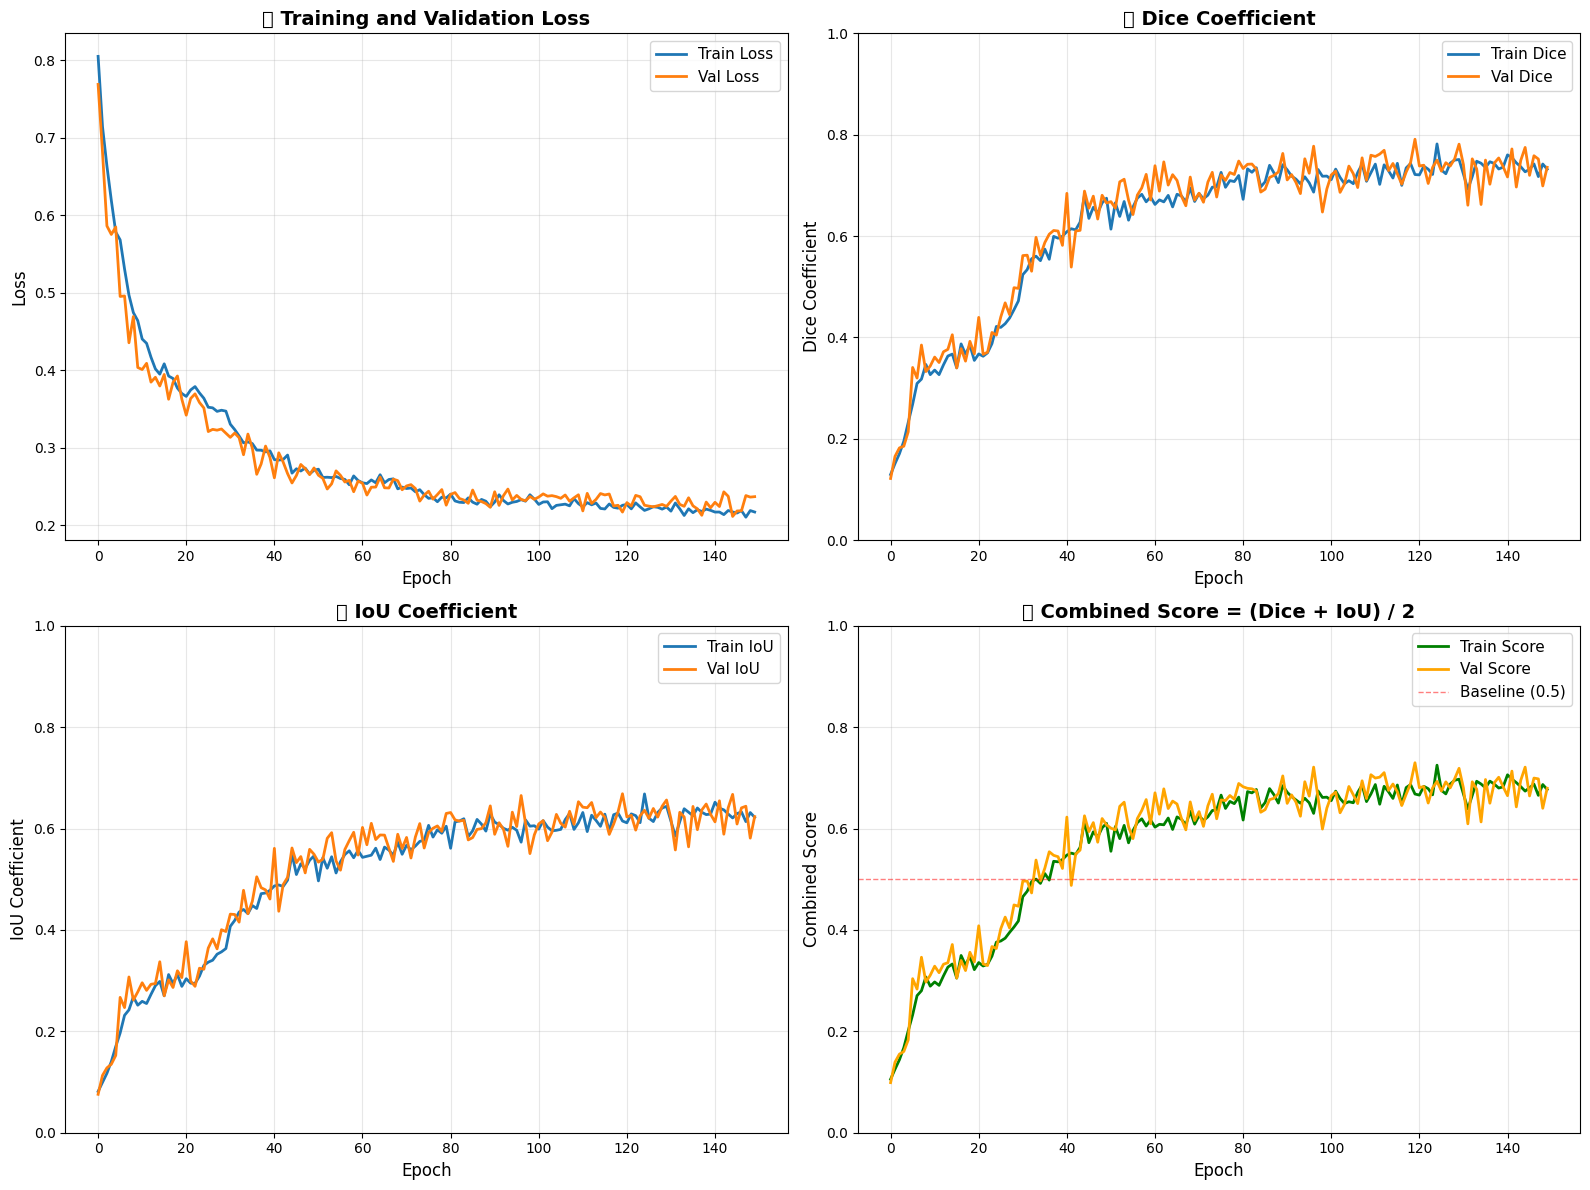

📊 訓練曲線已儲存到 training_curves.png


In [13]:
# 繪製訓練曲線
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('📉 Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Dice
axes[0, 1].plot(history['train_dice'], label='Train Dice', linewidth=2)
axes[0, 1].plot(history['val_dice'], label='Val Dice', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
axes[0, 1].set_title('🎯 Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# IoU
axes[1, 0].plot(history['train_iou'], label='Train IoU', linewidth=2)
axes[1, 0].plot(history['val_iou'], label='Val IoU', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU Coefficient', fontsize=12)
axes[1, 0].set_title('📊 IoU Coefficient', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Combined Score
axes[1, 1].plot(history['train_score'], label='Train Score', linewidth=2, color='green')
axes[1, 1].plot(history['val_score'], label='Val Score', linewidth=2, color='orange')
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Combined Score', fontsize=12)
axes[1, 1].set_title('🏆 Combined Score = (Dice + IoU) / 2', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print('📊 訓練曲線已儲存到 training_curves.png')


## 12. 測試最佳模型


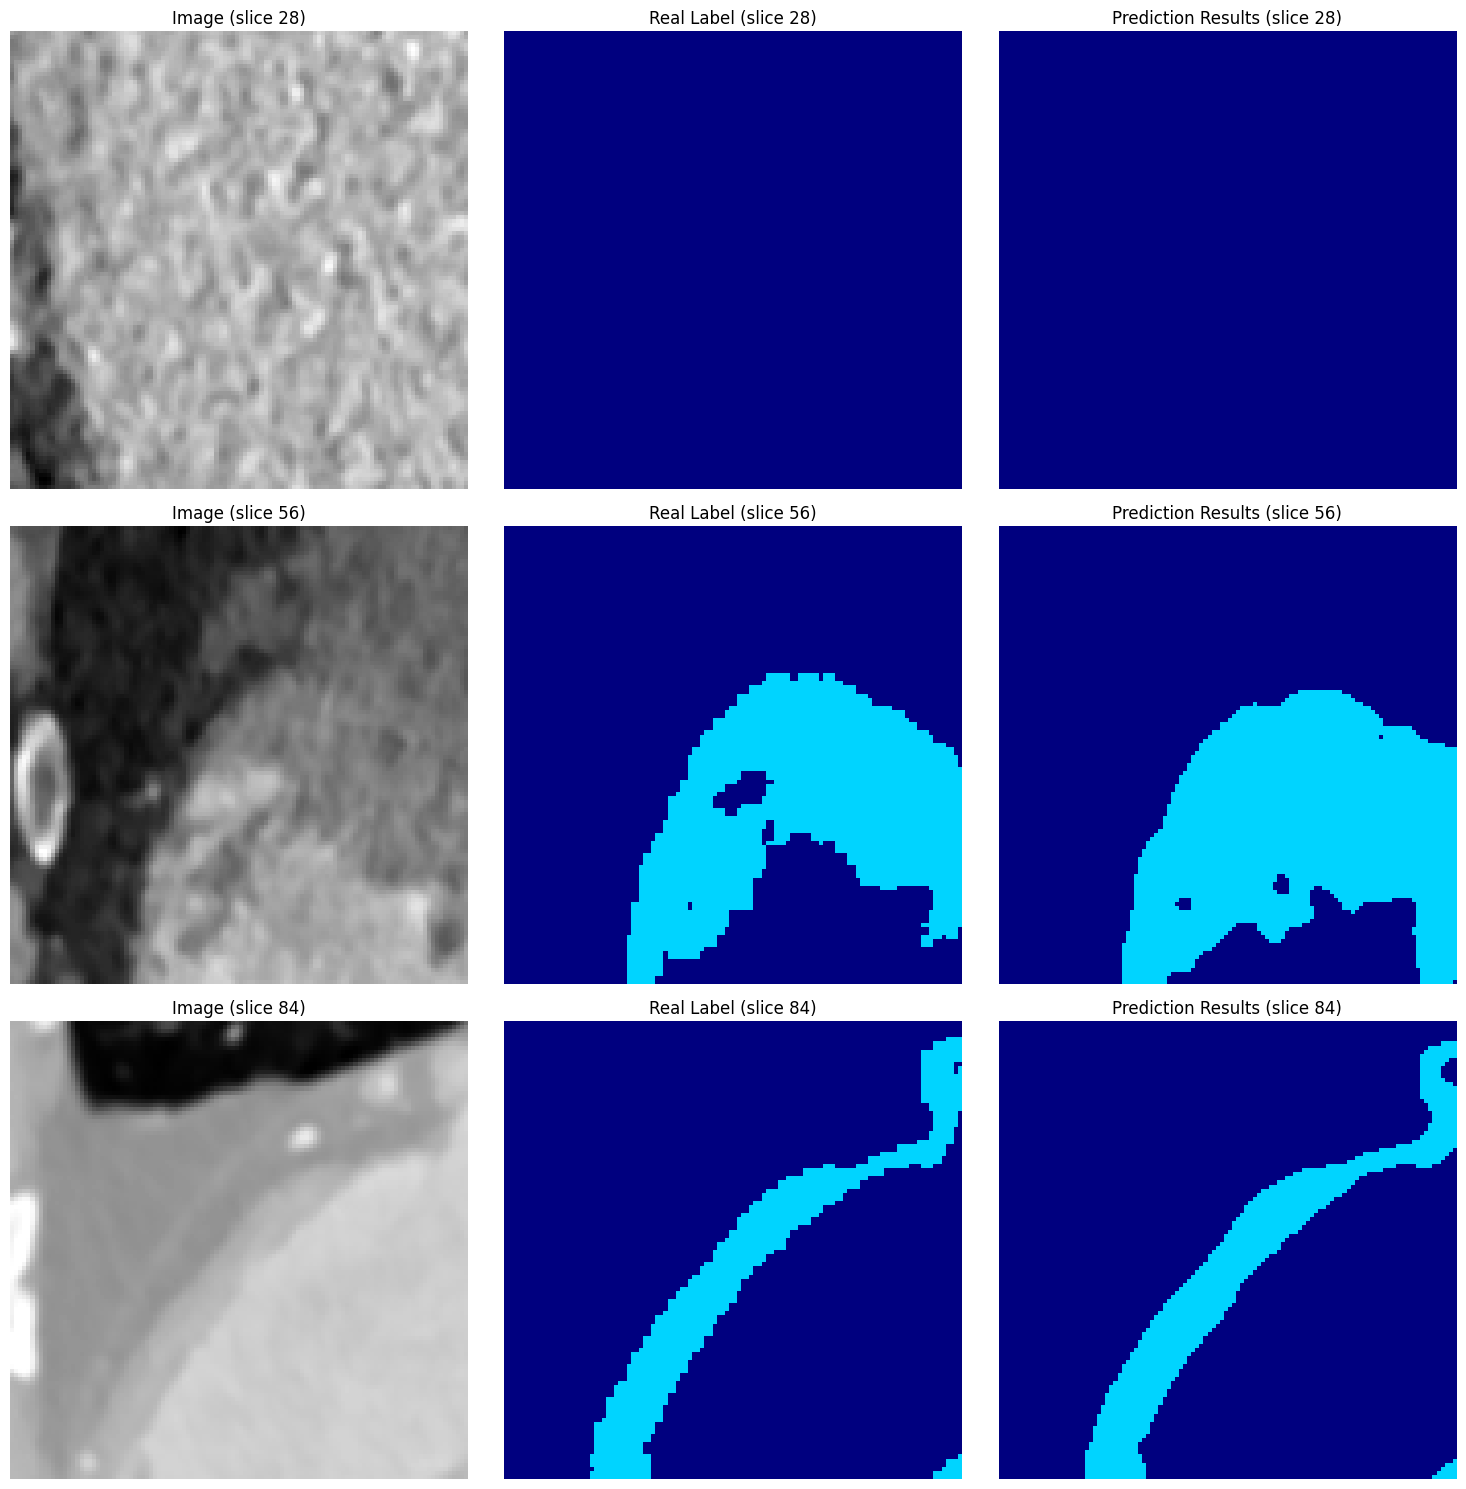

In [14]:
# 載入最佳模型
checkpoint = torch.load(os.path.join(SAVE_DIR, 'best_model.pth'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 視覺化驗證集的預測結果
val_image, val_label = val_dataset[0]
val_image_input = val_image.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(val_image_input)
    prediction = torch.argmax(prediction, dim=1).cpu().numpy()[0]

val_image = val_image.cpu().numpy()[0]
val_label = val_label.numpy()

# 顯示三個不同的切片
slice_indices = [val_image.shape[-1] // 4, val_image.shape[-1] // 2, 3 * val_image.shape[-1] // 4]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, slice_idx in enumerate(slice_indices):
    axes[i, 0].imshow(val_image[:, :, slice_idx], cmap='gray')
    axes[i, 0].set_title(f'Image (slice {slice_idx})')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(val_label[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[i, 1].set_title(f'Real Label (slice {slice_idx})')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(prediction[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[i, 2].set_title(f'Prediction Results (slice {slice_idx})')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('validation_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
import os
import shutil

# 重新定義 Google Drive 的 base_data_dir
base_data_dir = '/content/gdrive/MyDrive/aicup_data'

# 定義結果儲存目錄
results_dir = os.path.join(base_data_dir, 'aicup_results')
os.makedirs(results_dir, exist_ok=True)

# 最佳模型儲存的路徑 (來自訓練過程)
# 假設 SAVE_DIR 在訓練時是 'checkpoints'
model_source_path = os.path.join('checkpoints', 'best_model.pth')
model_destination_path = os.path.join(results_dir, 'best_model.pth')

# 複製最佳模型到 Google Drive
if os.path.exists(model_source_path):
    shutil.copy(model_source_path, model_destination_path)
    print(f'✅ 已將最佳模型 \'{model_source_path}\' 複製到 \'{model_destination_path}\'')
else:
    print(f'❌ 找不到最佳模型檔案：\'{model_source_path}\'。請確認訓練是否成功完成並產生了該檔案。')


✅ 已將最佳模型 'checkpoints/best_model.pth' 複製到 '/content/gdrive/MyDrive/aicup_data/aicup_results/best_model.pth'
